# CUSTOMER CHURN PREDICTION

### Import Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,RandomizedSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, f1_score,roc_auc_score,roc_curve
from scipy.stats import zscore
from sklearn.decomposition import PCA
from tabulate import tabulate


import warnings
warnings.filterwarnings('ignore')

## EDA

### Load the data

In [38]:
customer_churn_df = pd.read_excel('./Telco_customer_churn.xlsx')
customer_churn_df.head(3)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved


In [39]:
# columns of the dataset

customer_churn_df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [40]:
customer_churn_df.shape

(7043, 33)

Meaning of columns
* **

### [# Source](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)

### Demographics

`CustomerID`: A unique ID that identifies each customer.

`Count`: A value used in reporting/dashboarding to sum up the number of customers in a filtered set.

`Gender`: The customer’s gender: Male, Female

`Age`: The customer’s current age, in years, at the time the fiscal quarter ended.

`Senior Citizen`: Indicates if the customer is 65 or older: Yes, No

`Married`: Indicates if the customer is married: Yes, No

`Dependents`: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

`Number of Dependents`: Indicates the number of dependents that live with the customer.

 

### Location
`Country`: The country of the customer’s primary residence.

`State`: The state of the customer’s primary residence.

`City`: The city of the customer’s primary residence.

`Zip Code`: The zip code of the customer’s primary residence.

`Lat Long`: The combined latitude and longitude of the customer’s primary residence.

`Latitude`: The latitude of the customer’s primary residence.

`Longitude`: The longitude of the customer’s primary residence.

  

#### Services
`Tenure in Months`: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.

`Phone Service`: Indicates if the customer subscribes to home phone service with the company: Yes, No

`Multiple Lines`: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

`Internet Service`: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

`Online Security`: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

`Online Backup`: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

`Device Protection`: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

`Tech Support`: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

`Streaming TV`: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

`Streaming Movies`: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

`Contract`: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

`Paperless Billing`: Indicates if the customer has chosen paperless billing: Yes, No

`Payment Method`: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

`Monthly Charge`: Indicates the customer’s current total monthly charge for all their services from the company.

`Total Charges`: Indicates the customer’s total charges, calculated to the end of the quarter specified above.



#### Status
`Churn Label`: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

`Churn Value`: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.

`Churn Score`: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.

`CLTV`: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

`Churn Reason`: A customer’s specific reason for leaving the company. Directly related to Churn Category.

### Identifying Missing Values

In [41]:
def missing_values(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing_values_df = pd.DataFrame(missing, columns=['Missing Values'])
    missing_values_df.reset_index(inplace=True)
    missing_values_df.columns = ['Column Name', 'Missing Values']
    return missing_values_df


missing_values(customer_churn_df)

,Column Name,Missing Values
0,Churn Reason,5174


Data Types of features

In [42]:
def data_types(df):
    data_types_df = pd.DataFrame(df.dtypes, columns=['Data Type'])
    data_types_df.reset_index(inplace=True)
    data_types_df.columns = ['Column Name', 'Data Type']
    return data_types_df


data_types(customer_churn_df)

,Column Name,Data Type
0,CustomerID,object
1,Count,int64
2,Country,object
3,State,object
4,City,object
5,Zip Code,int64
6,Lat Long,object
7,Latitude,float64
8,Longitude,float64
9,Gender,object


### Counting Values for categorical values

In [43]:
def values_counts(df,column):
    counts = df[column].value_counts() # counts of unique values
    counts_df = pd.DataFrame(counts) # convert series to dataframe
    counts_df.reset_index(inplace=True)
    counts_df.columns = [column, 'Count']
    labels = counts_df[column].unique() # unique values
    values= counts_df['Count']

    plt.figure(figsize=(7,5))
    plt.pie(values, 
            labels=labels, 
            autopct='%1.1f%%', 
            startangle=90,
            wedgeprops={'edgecolor': 'white'},
        textprops={'fontsize': 10},
        pctdistance=0.85)
    
    centre_circle = plt.Circle((0,0),0.40,fc='white')
    fig = plt.gcf() # Get the current figure.
    fig.gca().add_artist(centre_circle) # current Axes instance on the current figure matching the given keyword args.
    plt.title(f'{column} Distribution in Customer Churn Prediction', fontsize=15)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

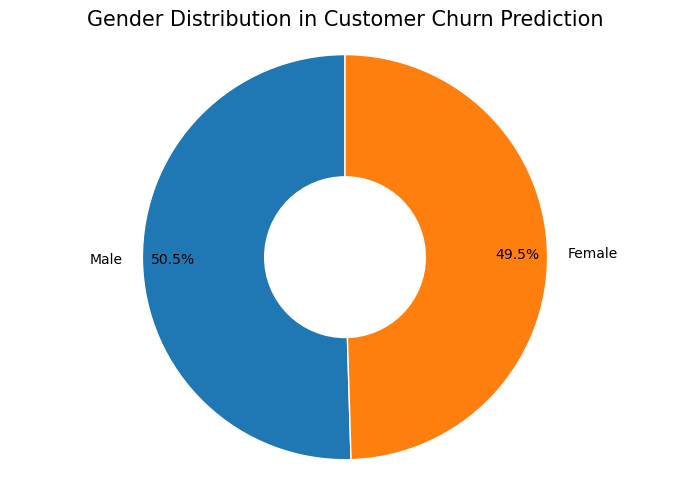

In [44]:
values_counts(customer_churn_df,'Gender')

- This shows that almost equal two genders are represented in data collection.

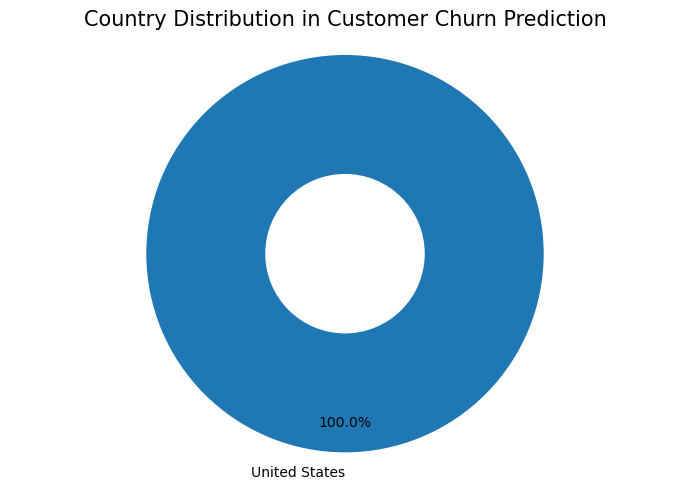

In [45]:
values_counts(customer_churn_df, 'Country')

- Data collection was carried out in US. 
- This means that this column will be dropped during model training

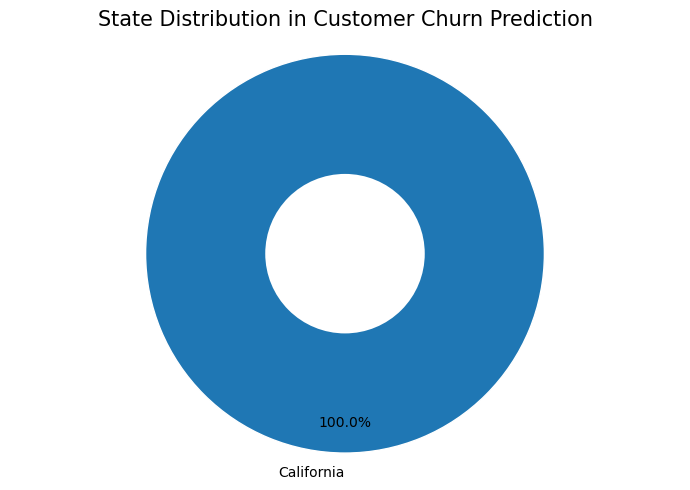

In [46]:
values_counts(customer_churn_df, 'State')

- Again all data collected are based in one state, California.
- This means that this column will also be unnecessary in model training.

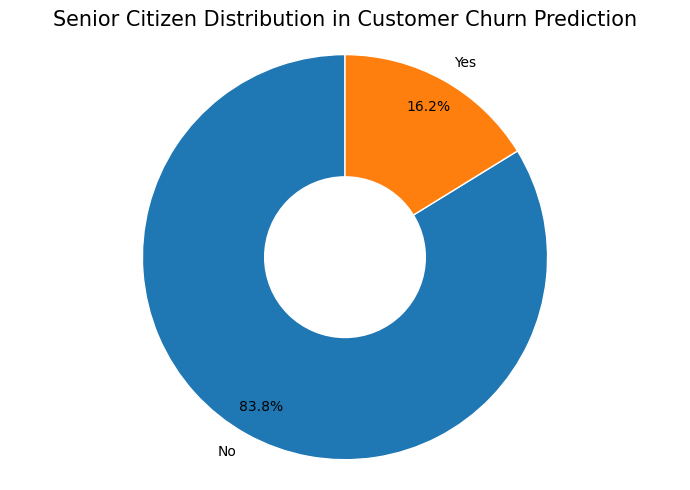

In [47]:
values_counts(customer_churn_df,'Senior Citizen')

- Dataset contains 16.2% who are >= 65 years old.
- This can reflect that old people are not dominant in tech industries, but it doesn't mean that they are not valuable clients.

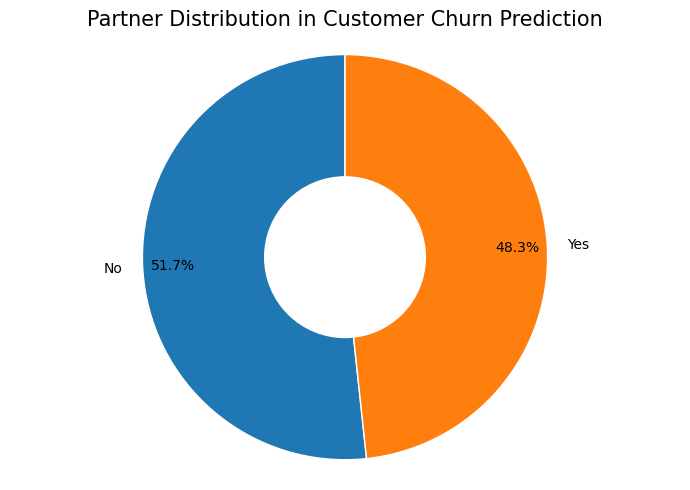

In [48]:
values_counts(customer_churn_df,'Partner')

- data collected shows that 48.3% of clients have partners.

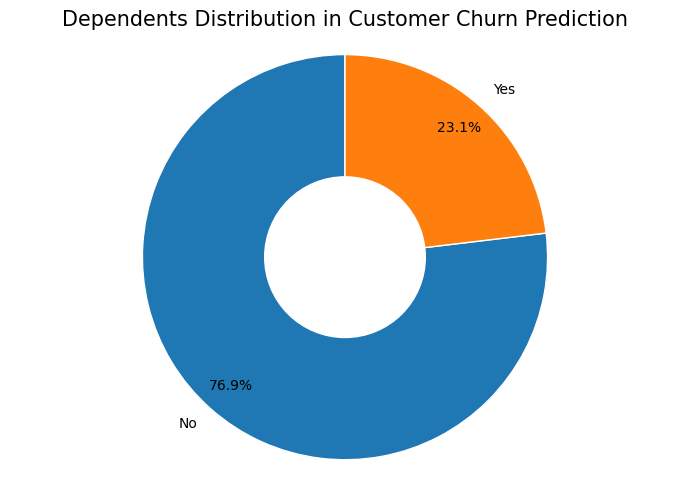

In [49]:
values_counts(customer_churn_df,'Dependents')

- Dataset shows that 76.9% of clients in dataset have no dependents like childern, parents, grand parents, etc.
- This indicates that the customer base primarily consists of single individuals or couples without children.
- This is probably because customers with dependents have other priorities compared to those without. For instance, Families may prioritise childcare,...

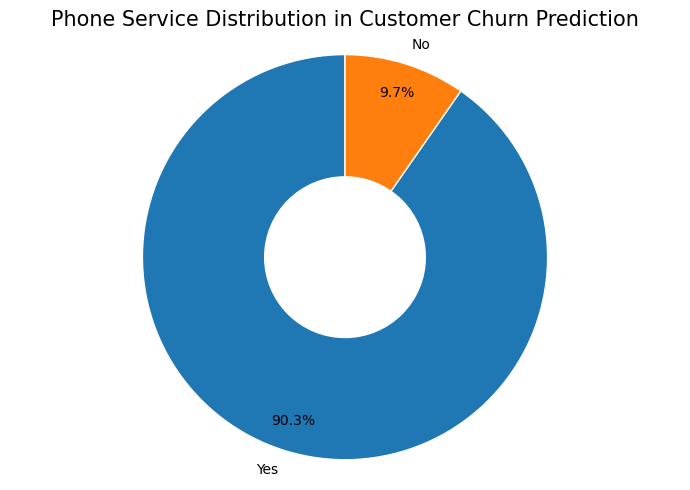

In [50]:
values_counts(customer_churn_df,'Phone Service')

- Dataset shows that 90.3% of clients subscribed to home phone services.
- Home phone services are seen as essential mainly due to reliablity and call quality or affordability.
- Knowing that most customers have subscribed to this service, company can focus on it with sorts of promotions.
- However company must also look how to introduce other technologies such as mobile services, VoIP.

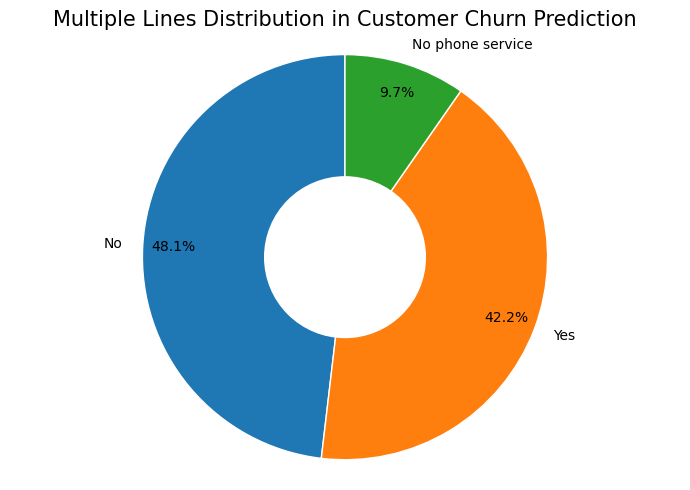

In [51]:
values_counts(customer_churn_df,'Multiple Lines')

- 48.1% only subscribed to only one line. This is due to simplicity and reducing costs. However this group is sensitive to churn as they are careful about prices/costs.
- 42.2% subscribed to more than one line. This can include businesses or people who have multiple lines for business/ work reasons. This group is higly valuable.
- 9.7% have no phone service. This group didn't like company preferences, they could be using internet services or no any service at all.

**During data collection, statistical results of `Multiple Lines` includes the result of `Phone Services`, this implies that `Phone Service` column can be removed and remain with `Multiple Lines`**

- This is because to have multiple line you must atleast have access to phone service. Hence `Phone Service` is redundant info.

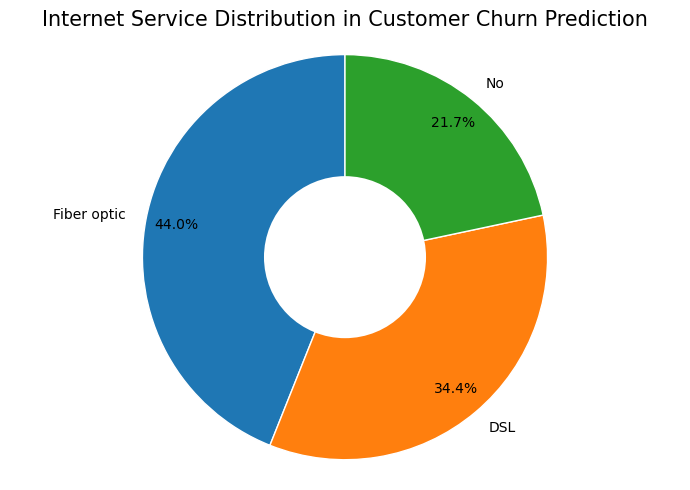

In [52]:
values_counts(customer_churn_df,'Internet Service')

- dataset shows that 44.0% subscribed to fiber optic internet service. This high percentage than others is due to fiber's high internet speed and reliablity.
- 34.4% subscribed to DSL internet service. These customers may be living in areas with no fiber or they are sensitive to prices. Company can try to teach them why upgrading to fiber is advantage. These customers are at high risk of churn as they care much about costs.
- 21.7% didn't subscribe to any of internet service. This indicate campaining opportunity for the company. These customers are probably relying on mobile data or those who don't use internet at all.

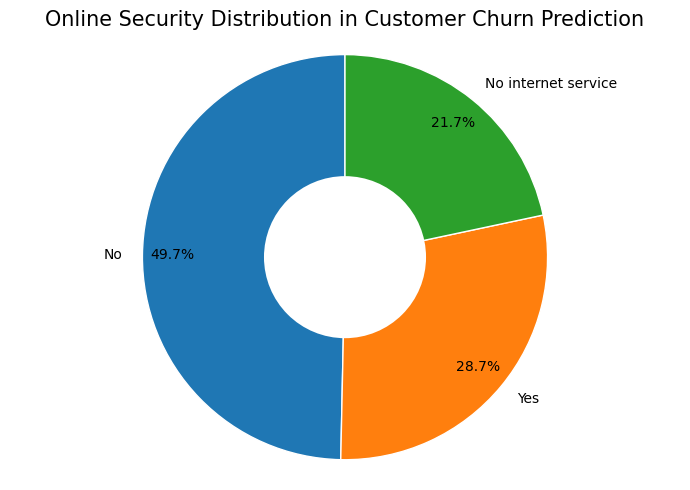

In [53]:
values_counts(customer_churn_df,'Online Security')

- data collected shows that 28.7% have subscribed to online security services. This implies that less than one-third of customers consider necessity of online security services such as firewalls, secure browsing or antivirus protection. This can include people who use online banking or e-commerce.
- 49.7% didn't subscribe to online security. Almost a half of the customers didn't subscribe to security services, this can be due to lack of awareness or don't need additional security measures. This is target for company when preparing marketing campains
- 21.7% have no internet service.

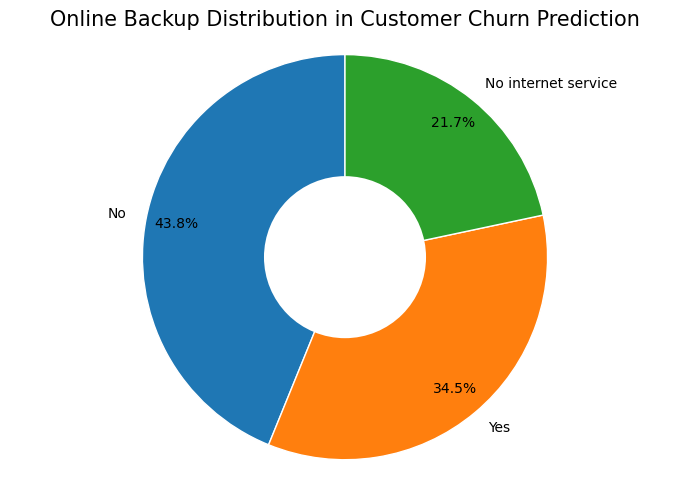

In [54]:
values_counts(customer_churn_df,'Online Backup')

- 34.5% have subscribed to online back up services. These can include people or businesses which keep sensitive information 
- 43.8% did not subscribed to back up services. Similar to other services, company can plan to organize marketing campaigns for raising awareness about benefits of backing up data.

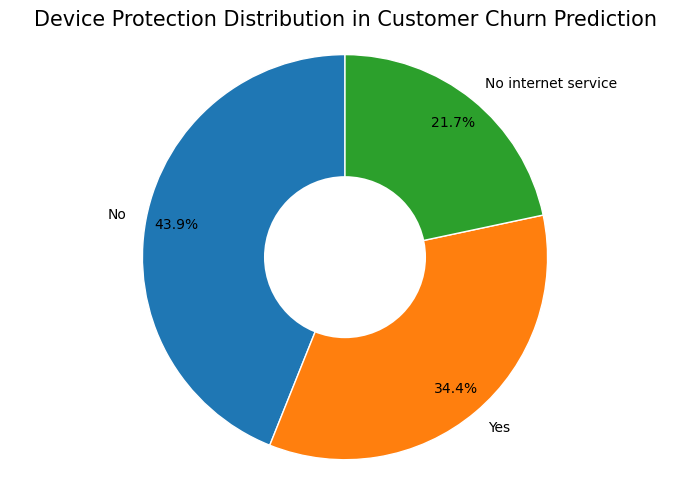

In [55]:
values_counts(customer_churn_df,'Device Protection')

- 34.4% of clients have subscribed to device protection services. This can include services like warranties, insurance against damage, loss or theft. To retain these customers require meeting their needs.
- 43.9% of clients didn't subscribe to device protection services. This could result from a lack of perceived need, concerns about costs, or a belief that such protection is unnecessary.
- 21.7% have no internet service.

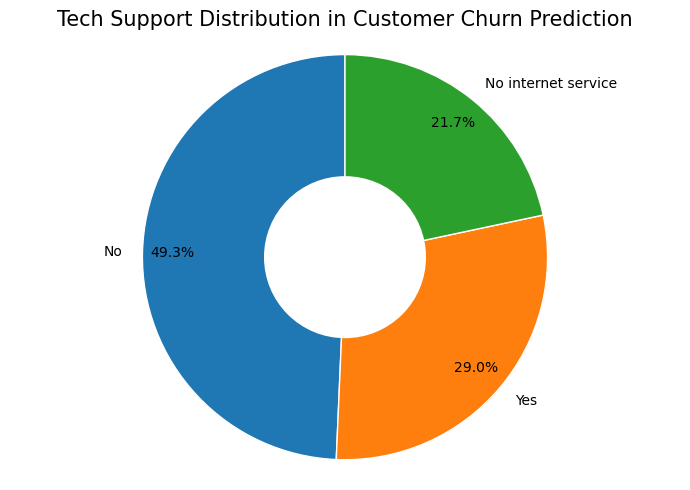

In [56]:
values_counts(customer_churn_df,'Tech Support')

- 29.0% subscribed to tech support
- 49.3% didn't subscribe to tech support. almost a half might be confident in their technical abilities or they seek nearby technical support probably to high cost of service.
- 21.7% have no internet service

**We can make one column that combines `Online Security`, `Device Protection`, `Tech Support` and `Online Backup` into one column of `Services` using feature engineering**

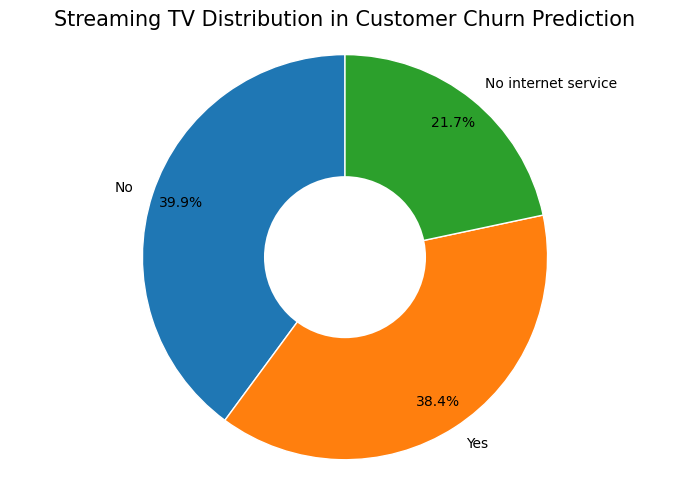

In [57]:
values_counts(customer_churn_df,'Streaming TV')

- 38.4% uses their internet services for TV streaming (a service from third party). This implies that this group need high speed and reliable internet service to support their usage. These customers are sensitive to service quality, internet speed.If they experience connectivity problems, they can switch to competitors.
- 39.9% don't use internet for TV streaming. This might be interest in traditional cable TV.
- 21.7% don't have internet service

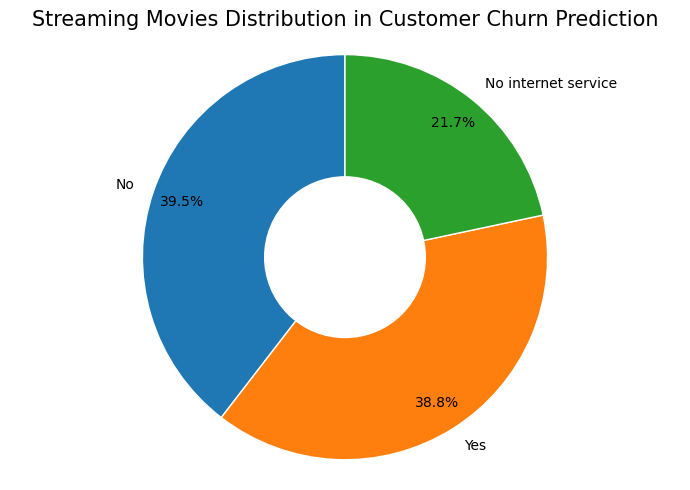

In [58]:
values_counts(customer_churn_df,'Streaming Movies')

- 39.5% do not stream movies using internet. Almost 40% of consumers do not watch movies on the internet. This demographic might not be interested in streaming or might rely on more conventional media (such as DVDs and cable TV).
- 38.8% stream movies from third party using internet service.
- 21.7% don't have internet service

**We can combine `Streaming TV` and `Streaming Movies` into one new column like `Streaming Services` when we will be reaching feature engineering.**

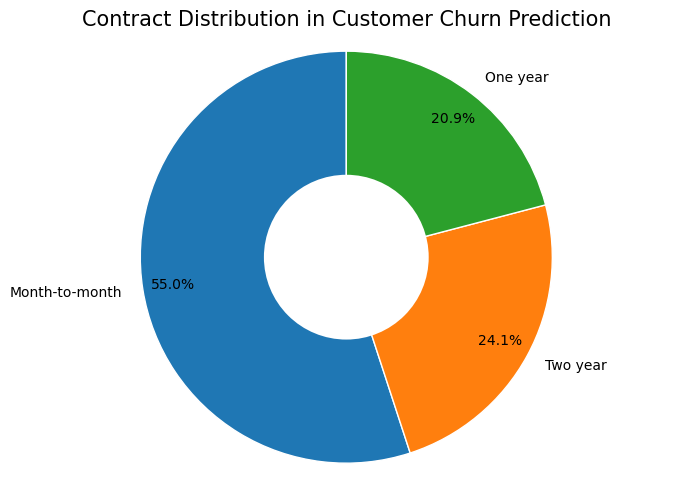

In [59]:
values_counts(customer_churn_df,'Contract')

- 55% of clients have month-to-month contract type of subscription. Month-to-month clients may be more likely to leave if they don't think the services are worth enough or if rivals have better offers. To keep these clients happy and involved, effective retention techniques should be used.
- 24.1% of clients have two year contract type. These are trustable clients and have very low risk of churning.
- and 20.9% of clients have one year contract type. Strategies to change them into two-years can be used.

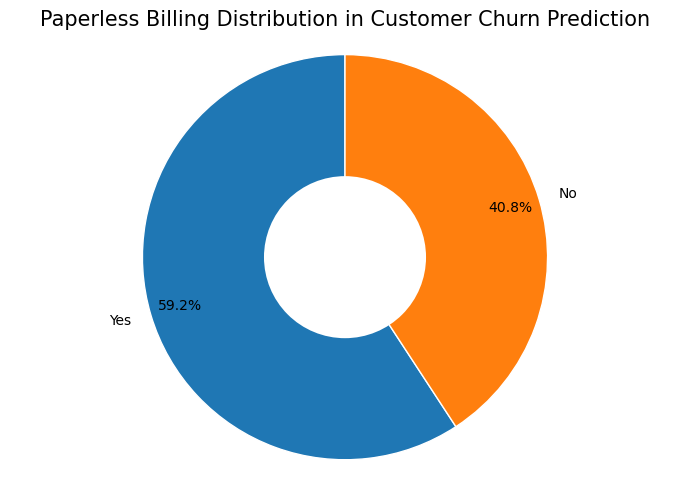

In [60]:
values_counts(customer_churn_df,'Paperless Billing')

- 59.2% of clients use paperless for billing. company can plan to educate these people also to use online security services.
- 40.8% use paper money for billing.

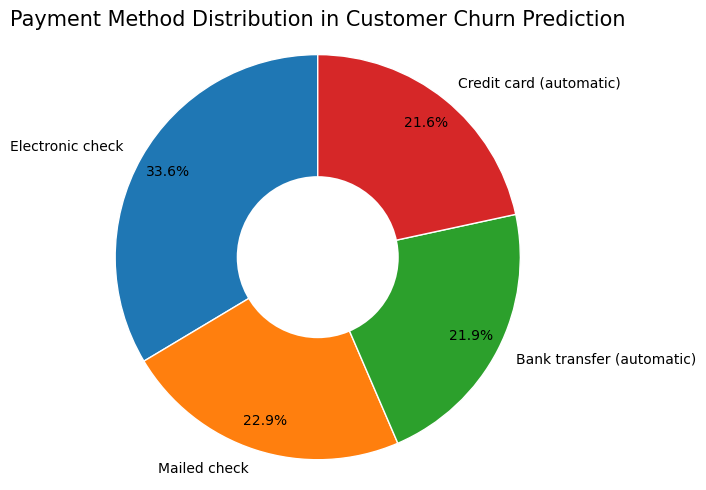

In [61]:
values_counts(customer_churn_df,'Payment Method')

- 33.6% use electronic check for payment. They may be cautious about using digital payments
- 21.6% use automatic credit card for payment. This is good option as it supports timely payments and less manual efforts.
- 21.9% use automatic bank transfer. This option is also convenient for company.
- 22.9% use mailed check. These people also may lack comfort with digital payment methods.

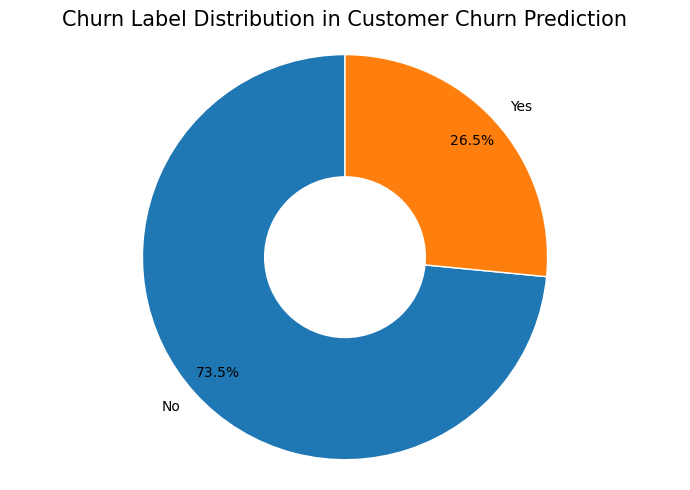

In [62]:
values_counts(customer_churn_df,'Churn Label')

- 73.5% didn't churn. With unsupervised learning we will know what made this majority to trust the company, which can be boosted for better services.
- 26.5% churned. This implies area of improvement

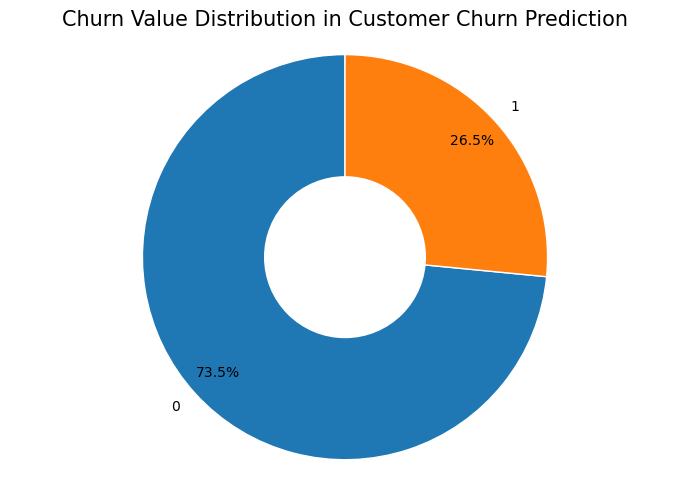

In [63]:
values_counts(customer_churn_df,'Churn Value')

- We can see that churn label and churn value signifies the same information, hence one column can be dropped.

### Feature Generation

1. Combining `Streaming TV` and `Streaming Movies`
* **

In [64]:
customer_churn_df['Streaming Services'] = customer_churn_df.apply(
    lambda row : 'TV & Movies' if row['Streaming TV'] == 'Yes' and row['Streaming Movies'] == 'Yes' 
                    else 'TV' if row['Streaming TV'] == 'Yes' and row['Streaming Movies'] == 'No' 
                    else 'Movies' if row['Streaming TV'] == 'No' and row['Streaming Movies'] == 'Yes' 
                    else 'No Streaming', axis=1
    )

# drop the columns after creating the new column
if all(col in customer_churn_df.columns for col in ['Streaming TV', 'Streaming Movies']):
    customer_churn_df.drop(['Streaming TV', 'Streaming Movies'], axis=1, inplace=True)


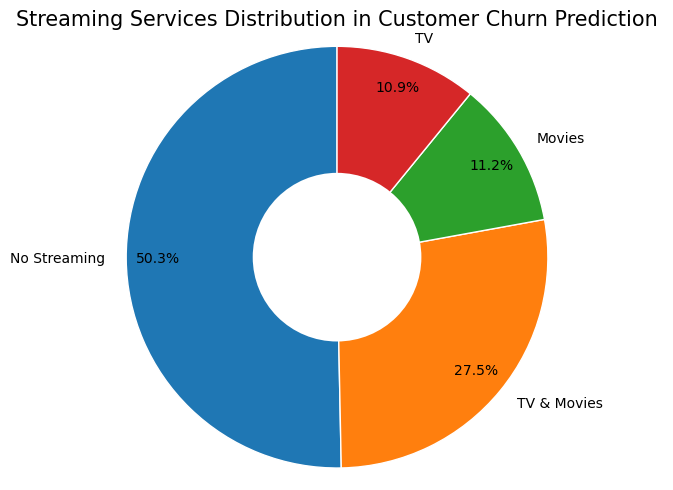

In [65]:
values_counts(customer_churn_df,'Streaming Services')

- 50.3% don't use streaming services. These customers' lack of use of streaming services suggests that they either prefer traditional media (such as DVDs or broadcast television), are uninterested in streaming, or may be unable to access streaming due to financial constraints.
- 27.5% stream both TV and Movies
- 11.2% use internet for streaming Movies only
- 10.9% use internet for streaming TV only

2. Combining `Online Security`, `Device Protection`, `Tech Support`, and `Online Backup` into new column
* **

In [66]:
services = {
    'Online Security': 'OS',
    'Device Protection': 'DP',
    'Tech Support': 'TS',
    'Online Backup': 'OB'
}

def combine_services(row):
    # Iterating through the `services` dictionary and check for 'Yes' in the row
    selected_services = [abbr for service, abbr in services.items() if row[service] == 'Yes']
    return ', '.join(selected_services) if selected_services else 'No Service'

if all(service in customer_churn_df.columns for service in services):
    customer_churn_df['Our Services'] = customer_churn_df.apply(combine_services, axis=1) # rowise
    # Drop the original service columns
    customer_churn_df.drop(columns=services.keys(), inplace=True)


### Dropping Some columns

- `CustomerID` must be removed as it is unique for each customer. It doesn't contribute to predictive modeling.
- `Count` must be dropped since it is value of counting rows.
- `Country` must be dropped since all data were collected in one state, US
- `State` must be dropped since all data were collected in one state, California
- `Churn Label` since it conveys similar info with `Churn Value`
- `Lat Long` since it is combination of two columns: `Latitude` and `Longitude`

In [67]:
cols_to_drop = ['CustomerID','Count','Country','State','Churn Label','Lat Long','Phone Service']

if all(col in customer_churn_df.columns for col in cols_to_drop):
    customer_churn_df.drop(cols_to_drop, axis=1, inplace=True)

In [68]:
customer_churn_df.columns

Index(['City', 'Zip Code', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Multiple Lines',
       'Internet Service', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Value', 'Churn Score',
       'CLTV', 'Churn Reason', 'Streaming Services', 'Our Services'],
      dtype='object')

### Distributions

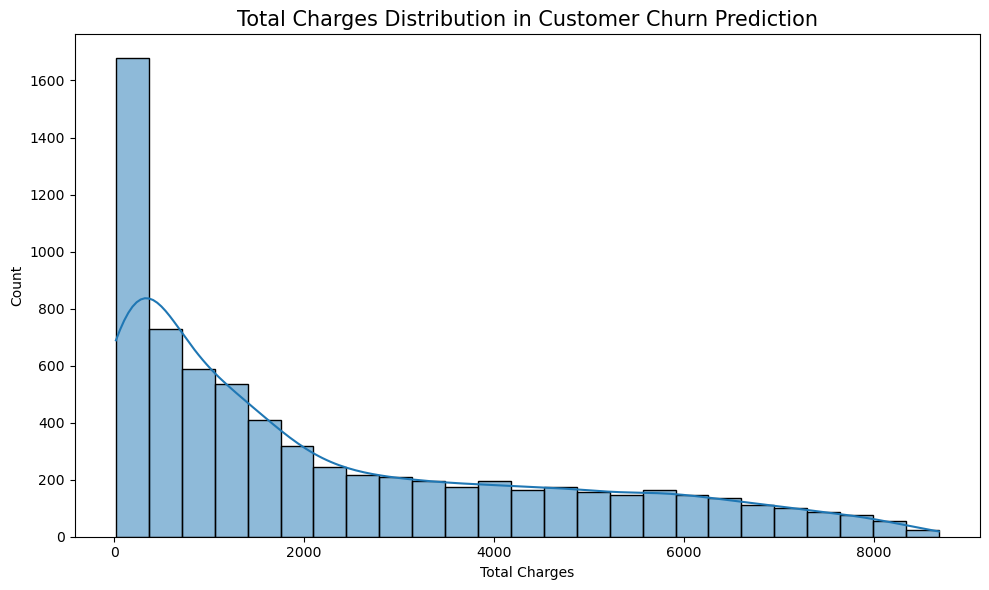

In [69]:
# Convert 'Total Charges' to numeric
customer_churn_df['Total Charges'] = pd.to_numeric(customer_churn_df['Total Charges'], errors='coerce') # 'coerce', then invalid parsing will be set as NaN.


def distribution_plot(df, column):
    plt.figure(figsize=(10,6))
    sns.histplot(data=df, x=column, kde=True)
    plt.title(f'{column} Distribution in Customer Churn Prediction', fontsize=15)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Total Charges distribution
distribution_plot(customer_churn_df, 'Total Charges')

- The distribution of total charges is biased to the right, with the majority of clients having comparatively modest total charges. Many clients have smaller cumulative charges, as evidenced by the notable peak at the lower end (around zero).

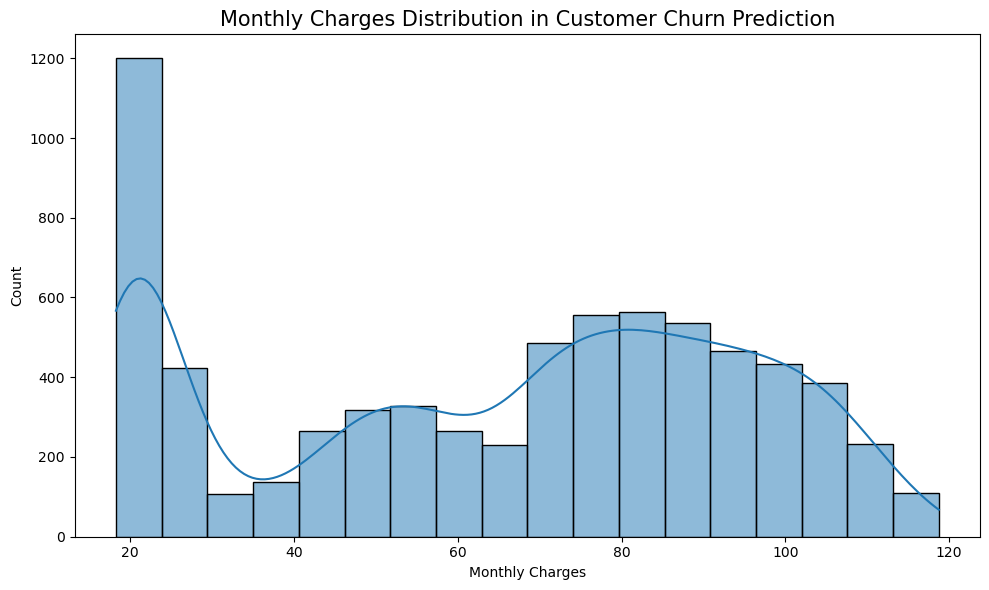

In [70]:
distribution_plot(customer_churn_df, 'Monthly Charges')

- Around $20, there is a significant peak indicating that large number of customers have monthly charges around that amount. This can also indicate that many clients have subscribed to basic plans or no subscriptions.

- There is a declining number of users at the higher end of the charge spectrum, suggesting a small group that may have premium or complete service plans.

- Customers with higher monthly charges could be at greater risk of churn if they perceive the cost as not justifiable compared to the perceived value of the service. Conversely, customers on lower monthly charge plans may churn based on seeking better deals or services from competitors.

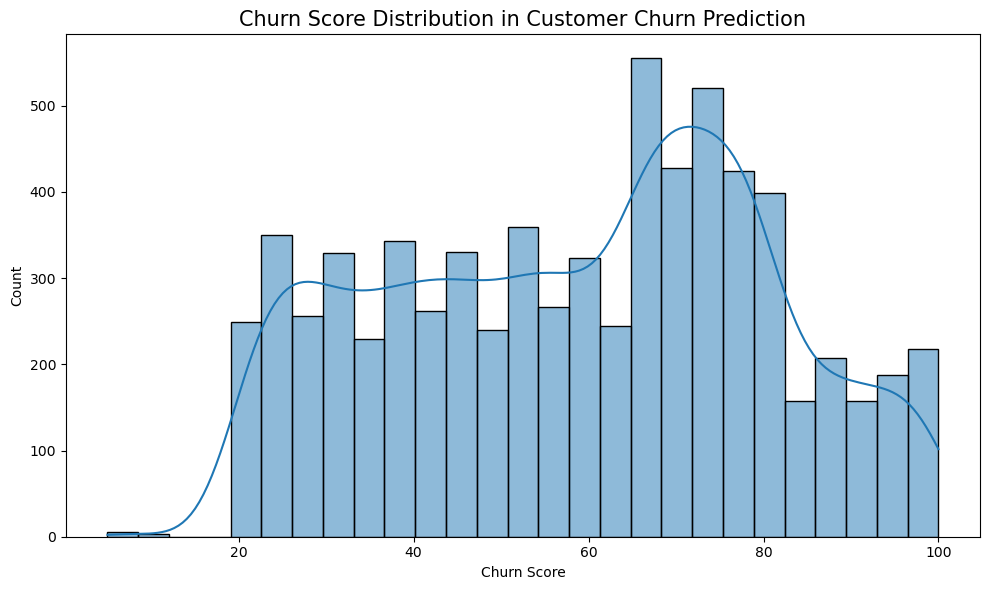

In [71]:
distribution_plot(customer_churn_df, 'Churn Score')

- Only a tiny percentage of consumers have extremely low churn scores (0–18), suggesting that they are a stable and less prone to leave. This group can be recognized as either devoted consumers or loyal customers.

- High risk: On the other hand, the bars with scores higher than 80 indicate a noticeable decrease in the number of customers. This suggests that extreme churn risk may not be as common because, although there are some customers with very high churn scores, they are low in numbers.

- One can segment customers into:
Low Risk (0-30): Company can focus on customer appreciation programs.
Moderate Risk (31-70): Company can implement targeted retention efforts and engagement strategies.
High Risk (71-100): Company can prioritize intensive retention strategies, potentially including offers, or promotions.

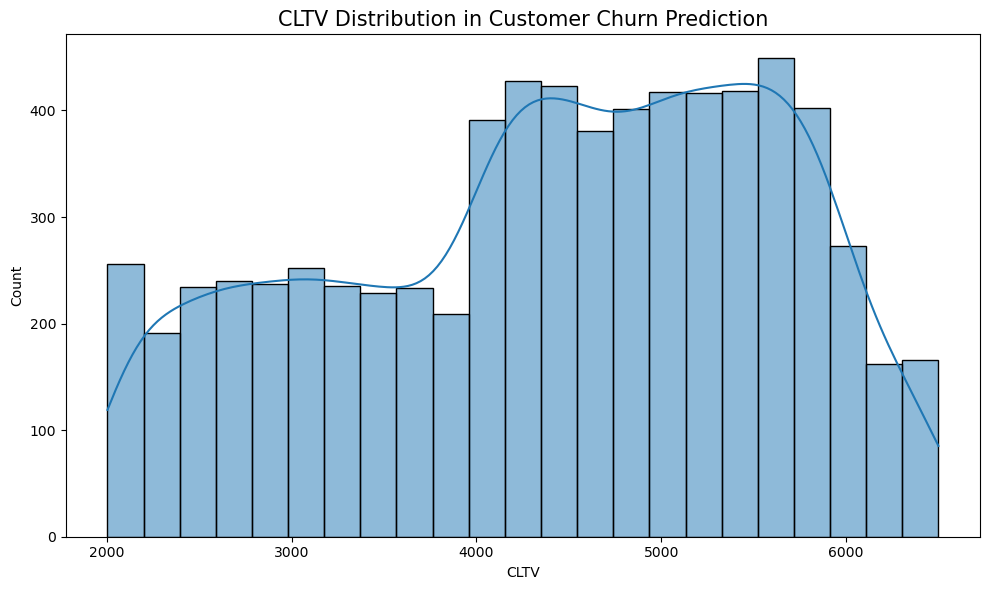

In [72]:
distribution_plot(customer_churn_df, 'CLTV')

- The graph indicates a bimodal distribution showing two distinct groups of customers in terms of their lifetime value.
- The left tail of the distribution (around $2,000-$3,900) indicates a smaller number of customers with low CLTV, which may represent less engaged or less profitable customers.
- The right tail shows a gradual decline, suggesting fewer customers have very high CLTV (above $4,000). These high-value customers should be closely monitored for churn, as their departure could significantly impact overall revenue.


### Handling Missing Values

In [73]:
missing_values(customer_churn_df)

,Column Name,Missing Values
0,Total Charges,11
1,Churn Reason,5174


In [74]:
customer_churn_df['Churn Reason'].value_counts()

Churn Reason
Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Limited range of services                     44
Long distance charges                         44
Lack of affordable download/upload speed      44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: c

In [75]:
# filling total charges missing values with the prorduct of monthly charges and tenure months

customer_churn_df.fillna({
    'Total Charges': customer_churn_df['Monthly Charges']*customer_churn_df['Tenure Months']
},inplace=True)

In [76]:
# value counts for churn reason

customer_churn_df['Churn Reason'].value_counts()

Churn Reason
Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Limited range of services                     44
Long distance charges                         44
Lack of affordable download/upload speed      44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: c

In [77]:
# we can rename some reasons and no reason to one combined reason

meaningless_reasons =['Don\'t know','Deceased','Moved']

customer_churn_df['Churn Reason'] = customer_churn_df['Churn Reason'].apply(
    lambda reason: 'No Reason' if pd.isnull(reason) or reason in meaningless_reasons else reason
)

### Correlation Matrix

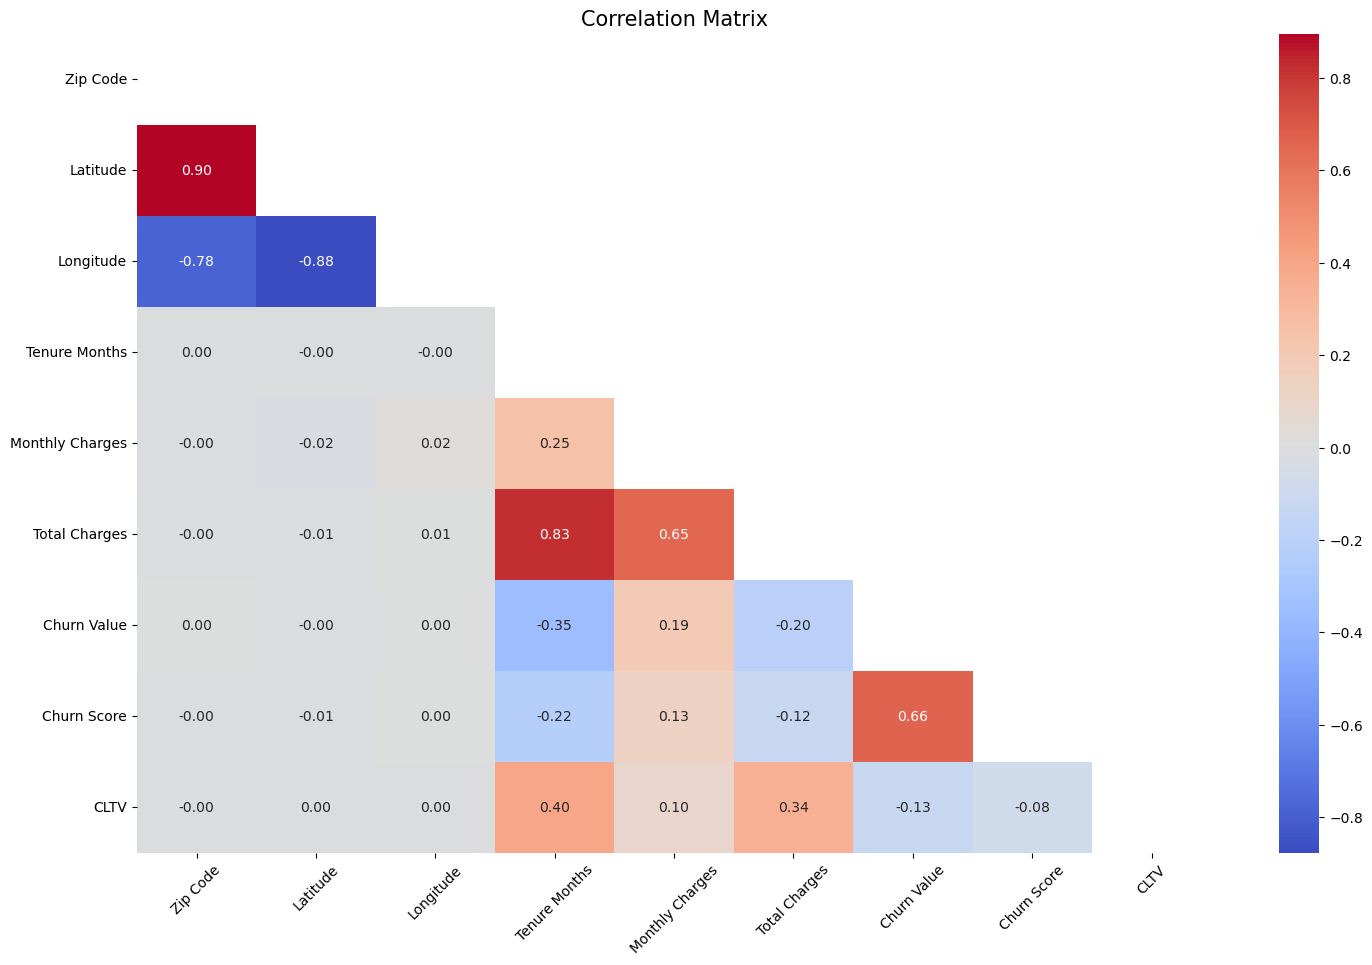

In [78]:
correlation_matrix = customer_churn_df.corr(numeric_only=True)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix', fontsize=15)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

   - **Latitude & Zip Code (0.90)**: This indicates a very strong positive correlation between these two variables. This is because they are both representing geographical location.
   - **Total Charges & CLTV (0.34)**: A moderate positive correlation suggests that customers with higher total charges tend to have higher Customer Lifetime Values (CLTV). This can imply that higher charges mean higher customer value.
   - **Churn Value & Churn Score (0.66)**:  A customer with higher churn score is likely to be loyal customer.
   - **Churn Value with Total Charges (-0.2)**: This negative correlation suggests that churn values are associated with lower total charges. This could imply that lower spenders are more likely to churn.

**From Correlation Matrix above, We can see that locational Coordinates (ZipCode, Latitude, Longitude) are highly correlated between themselves `Multicollinearity`. Again they have zero correlation with `Target Variable`, hence we can also drop them.**

In [79]:
geo_locations= ['Zip Code','Latitude','Longitude']

if all(col in customer_churn_df.columns for col in geo_locations):
    customer_churn_df.drop(geo_locations, axis=1, inplace=True)

In [80]:
customer_churn_df.head(3)

,City,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Multiple Lines,Internet Service,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV,Churn Reason,Streaming Services,Our Services
0,Los Angeles,Male,No,No,No,2,No,DSL,Month-to-month,Yes,Mailed check,53.85,108.15,1,86,3239,Competitor made better offer,No Streaming,"OS, OB"
1,Los Angeles,Female,No,No,Yes,2,No,Fiber optic,Month-to-month,Yes,Electronic check,70.70,151.65,1,67,2701,No Reason,No Streaming,No Service
2,Los Angeles,Female,No,No,Yes,8,Yes,Fiber optic,Month-to-month,Yes,Electronic check,99.65,820.50,1,86,5372,No Reason,TV & Movies,DP


#### How Different features move with Churn Value?


In [81]:
def feature_by_churn_value(df, feature):
    """
    Plots the count of a specified feature in the dataframe, grouped by 'Churn Value'.
    """

    plt.figure(figsize=(6, 5))
    ax = sns.countplot(data=df, x=feature, hue='Churn Value')
    
    for bar in ax.patches: # Adding the count of the value on top of the bar
        count = int(bar.get_height())
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        ax.text(x, y, str(count), ha='center', va='bottom', fontsize=10)
    
    # Add titles and labels
    plt.title(f'{feature} by Churn Value', fontsize=15)
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

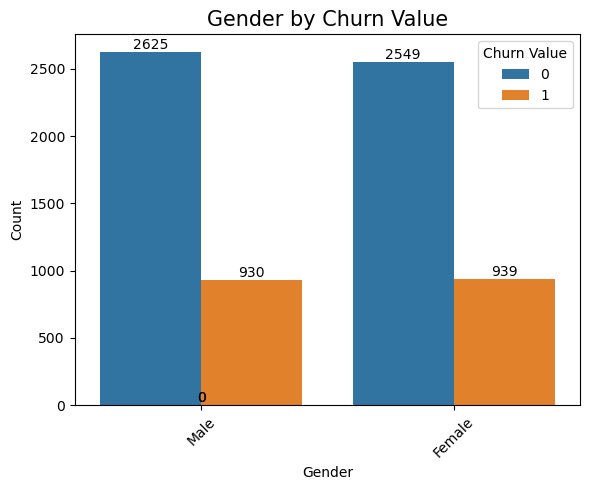

In [82]:
feature_by_churn_value(customer_churn_df,'Gender')

- The churn rate appears to be slightly higher among female customers when considered in absolute numbers (about 26.93% female churn versus approximately 26.12% male churn). However, the difference is not substantial, suggesting that gender may not be a significant factor influencing churn, though females show a slightly higher churn proportionally.

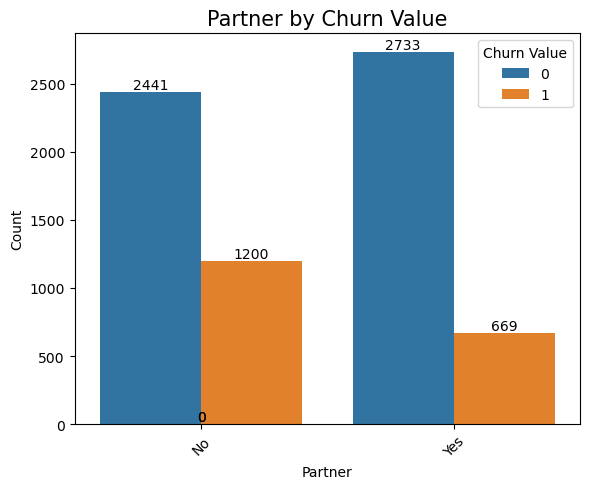

In [83]:
feature_by_churn_value(customer_churn_df,'Partner')

- Customers with partners have a lower churn rate compared to those without partners. This suggests that partnership status make customers feel more secure in their service choices when they have a partner.

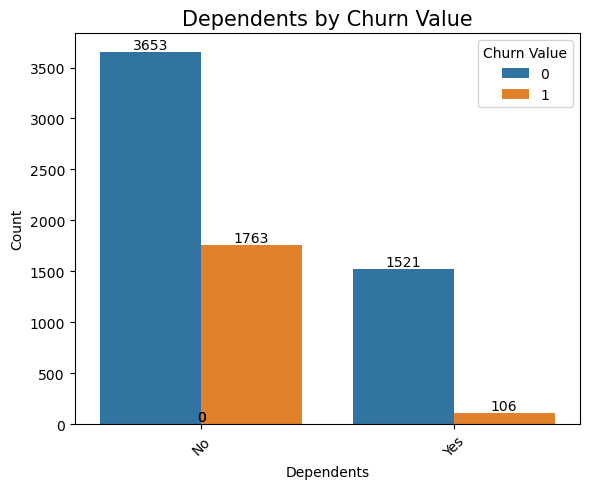

In [84]:
feature_by_churn_value(customer_churn_df,'Dependents')

- Customers without dependents are both more numerous and exhibit a higher churn rate

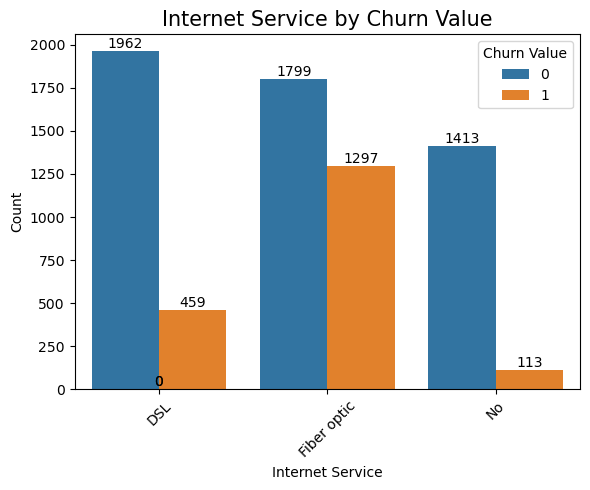

In [85]:
feature_by_churn_value(customer_churn_df,'Internet Service')

- Fiber optic users are at high risk of churning suggesting some experiences of low speeds of internet.

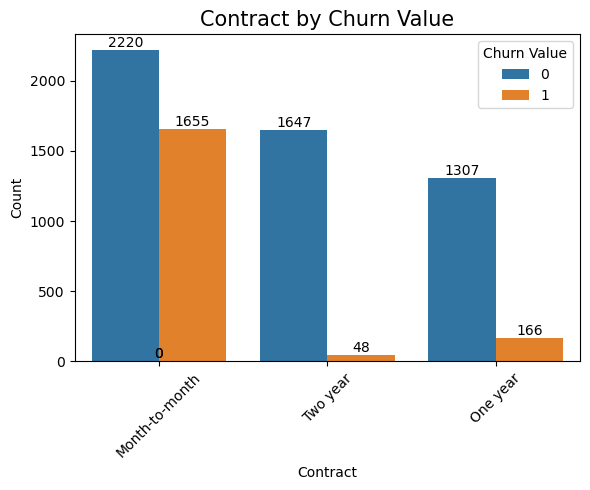

In [86]:
feature_by_churn_value(customer_churn_df,'Contract')

- As the customers have short-term contract period, the more likely are to churn.

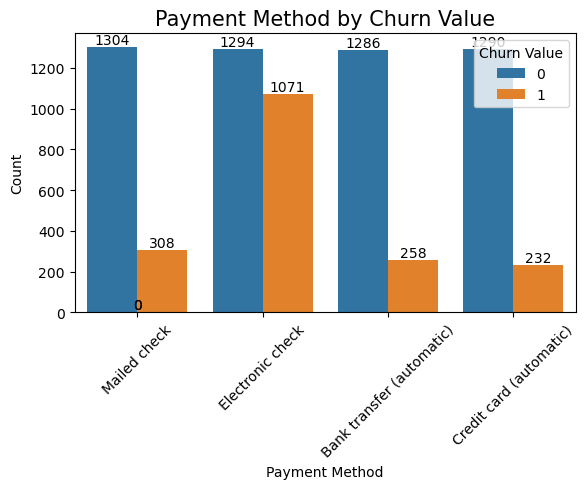

In [87]:
feature_by_churn_value(customer_churn_df,'Payment Method')

- The high churn for electronic checks suggests that these customers may face issues, such as dissatisfaction with payment processing

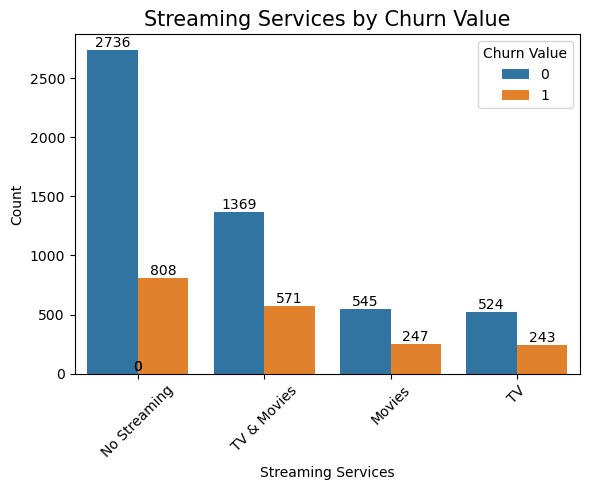

In [88]:
feature_by_churn_value(customer_churn_df,'Streaming Services')

- Customers who do not use any streaming services are more likely to churn compared to those with streaming options. It suggests  having streaming services could enhance value perception and reduce churn.

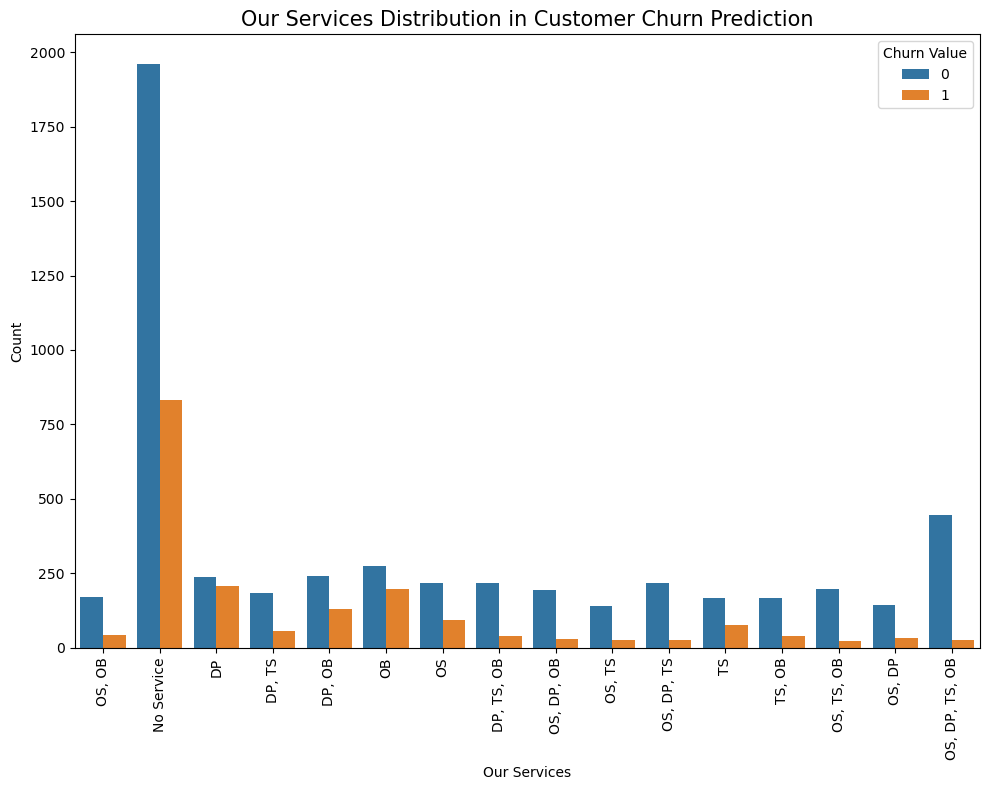

In [89]:
# count plot for our services
plt.figure(figsize=(10,8))
sns.countplot(data=customer_churn_df, x='Our Services', hue='Churn Value')
plt.title('Our Services Distribution in Customer Churn Prediction', fontsize=15)
plt.xlabel('Our Services')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- It can be seen that When clients don't use one of company's services, they are more likely to churn.
- Again for clients who use more than one service, they are less likely to churn compared to those who use only one service.

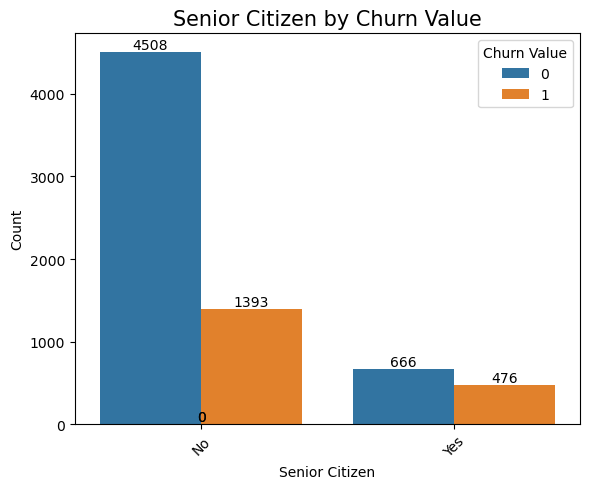

In [90]:
feature_by_churn_value(customer_churn_df,'Senior Citizen')

In [91]:
customer_churn_df_copy = customer_churn_df.copy()

### Encoding

1. Label Encoding
* **

In [92]:
label_encoder = LabelEncoder()
def label_encoding(df, binary_columns):
    for column in binary_columns:
        df[column] = label_encoder.fit_transform(df[column])
    return df

binary_columns =[column for column in customer_churn_df_copy.columns if customer_churn_df_copy[column].nunique() == 2]

customer_churn_df_copy= label_encoding(customer_churn_df_copy, binary_columns)
customer_churn_df_copy['Multiple Lines'] = label_encoder.fit_transform(customer_churn_df_copy['Multiple Lines'])

In [93]:
print(binary_columns)

['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Paperless Billing', 'Churn Value']


2. One Hot Encoding
* **

In [94]:
one_hot_encoder = OneHotEncoder()

def one_hot_encoding(df, columns):
    for column in columns:
        one_hot_encoded = one_hot_encoder.fit_transform(df[[column]]).toarray()
        one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=[column+'_'+str(int(i)) for i in range(one_hot_encoded.shape[1])])
        df = pd.concat([df, one_hot_encoded_df], axis=1)
        df.drop(column, axis=1, inplace=True)
    return df



cols_for_hot_encoding =['Payment Method','Contract','Streaming Services','Internet Service']

if all(col in customer_churn_df_copy.columns for col in cols_for_hot_encoding):
    customer_churn_df_copy = one_hot_encoding(customer_churn_df_copy, cols_for_hot_encoding)

3. Frequency Encoding
* **

For columns with many values, we will use frequency encoding.

In [95]:

# frequency encoding for categorical columns
city_counts = customer_churn_df_copy['City'].value_counts()
customer_churn_df_copy['City'] = customer_churn_df_copy['City'].map(city_counts)

4. Target Encoding
* **

- With target encoding each value will be represented by its Mean
- This is used when we have high number of unique values, using one-hot-encoding can lead to curse of dimensionality
- This is good as it captures relationships between column and target variable

In [96]:

def target_encoding(df, column, target):
    target_means = df.groupby(column)[target].mean()
    df[column] = df[column].map(target_means)
    return df


# target encoding on 'Our Services' column
customer_churn_df_copy = target_encoding(customer_churn_df_copy, 'Our Services', 'Churn Value')

# Target encoding for 'Churn Reason'
customer_churn_df_copy = target_encoding(customer_churn_df_copy, 'Churn Reason', 'Churn Value')

In [97]:
customer_churn_df_copy.head()

,City,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Multiple Lines,Paperless Billing,Monthly Charges,Total Charges,...,Contract_0,Contract_1,Contract_2,Streaming Services_0,Streaming Services_1,Streaming Services_2,Streaming Services_3,Internet Service_0,Internet Service_1,Internet Service_2
0,305,1,0,0,0,2,0,1,53.85,108.15,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,305,0,0,0,1,2,0,1,70.70,151.65,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,305,0,0,0,1,8,2,1,99.65,820.50,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,305,0,0,1,1,28,2,1,104.80,3046.05,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,305,1,0,0,1,49,2,1,103.70,5036.30,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [98]:
data_types(customer_churn_df_copy)

,Column Name,Data Type
0,City,int64
1,Gender,int32
2,Senior Citizen,int32
3,Partner,int32
4,Dependents,int32
5,Tenure Months,int64
6,Multiple Lines,int32
7,Paperless Billing,int32
8,Monthly Charges,float64
9,Total Charges,float64


### Outliers Detection

In [99]:

# Calculate Z-scores for numerical columns
z_scores = customer_churn_df_copy.apply(zscore)

# Identify outliers where Z-score >= 3
outliers = (z_scores.abs() > 3).any(axis=1)
# Filter out the outliers
outliers_df = customer_churn_df_copy[outliers]

customer_churn_df_copy = customer_churn_df_copy[~outliers]

# Check the shape before and after removing outliers
print(f"Cleaned Df shape: {customer_churn_df_copy.shape}")
print(f"Outliers shape: {outliers_df.shape}")

Cleaned Df shape: (6738, 29)
Outliers shape: (305, 29)


### Data Scaling

In [100]:
X = customer_churn_df_copy.drop('Churn Value', axis=1) # independent variables
y = customer_churn_df_copy['Churn Value'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y, shuffle=True)


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape: ", X_train_scaled.shape)
print("X_test_scaled shape: ", X_test_scaled.shape)

X_train_scaled shape:  (5053, 28)
X_test_scaled shape:  (1685, 28)


##### Summary Table of Transformations Applied


In [101]:


feature_transformations = [
    ["Feature", "Transformation", "Details"],
    ["Total Charges", "Missing Value Imputation", "Filled missing values using 'Monthly Charges' * 'Tenure Months'"],
    ["Streaming TV & Movies", "Feature Generation", "Combined into a new feature 'Streaming Services'"],
    ["Online Security, Device Protection, Tech Support, Online Backup", "Feature Generation", "Combined into 'Our Services'"],
    ["CustomerID, Count, Country, State, etc.", "Feature Removal", "Dropped as irrelevant or redundant"],
    ["City", "Frequency Encoding", "Encoded based on city value counts"],
    ["Our Services, Churn Reason", "Target Encoding", "Encoded using mean 'Churn Value' for each category"],
    ["Gender, Senior Citizen, Partner, etc.", "Label Encoding", "Binary encoding applied"],
    ["Contract, Payment Method, etc.", "One-Hot Encoding", "Created dummy variables"],
    ["Zip Code, Latitude, Longitude", "Feature Removal", "Dropped due to multicollinearity and irrelevance"],
    ["Numerical Features", "Scaling", "Standardized using StandardScaler"],
    ["Outliers", "Removal", "Removed based on Z-score threshold of ±3"],
]

table = tabulate(feature_transformations, headers="firstrow", tablefmt="fancy_grid")

# Print the table
print(table)


╒═════════════════════════════════════════════════════════════════╤══════════════════════════╤═════════════════════════════════════════════════════════════════╕
│ Feature                                                         │ Transformation           │ Details                                                         │
╞═════════════════════════════════════════════════════════════════╪══════════════════════════╪═════════════════════════════════════════════════════════════════╡
│ Total Charges                                                   │ Missing Value Imputation │ Filled missing values using 'Monthly Charges' * 'Tenure Months' │
├─────────────────────────────────────────────────────────────────┼──────────────────────────┼─────────────────────────────────────────────────────────────────┤
│ Streaming TV & Movies                                           │ Feature Generation       │ Combined into a new feature 'Streaming Services'                │
├─────────────────────────────────

### UNSUPERVISED LEARNING

#### K-Means Clustering

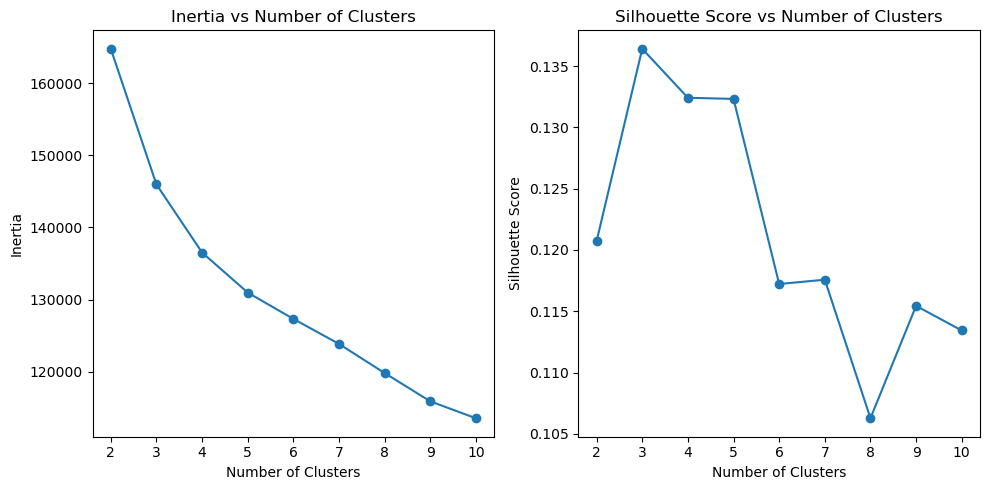

In [102]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# K-Means clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# finding optimal number of clusters

inertia =[]
silhoutte =[]

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhoutte.append(silhouette_score(X_scaled, kmeans.labels_))


# plotting the results

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(2,11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')


plt.subplot(1,2,2)
plt.plot(range(2,11), silhoutte, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.tight_layout()
plt.show()

- Number of clusters with high `Silhoute Score` is the optimal choice.

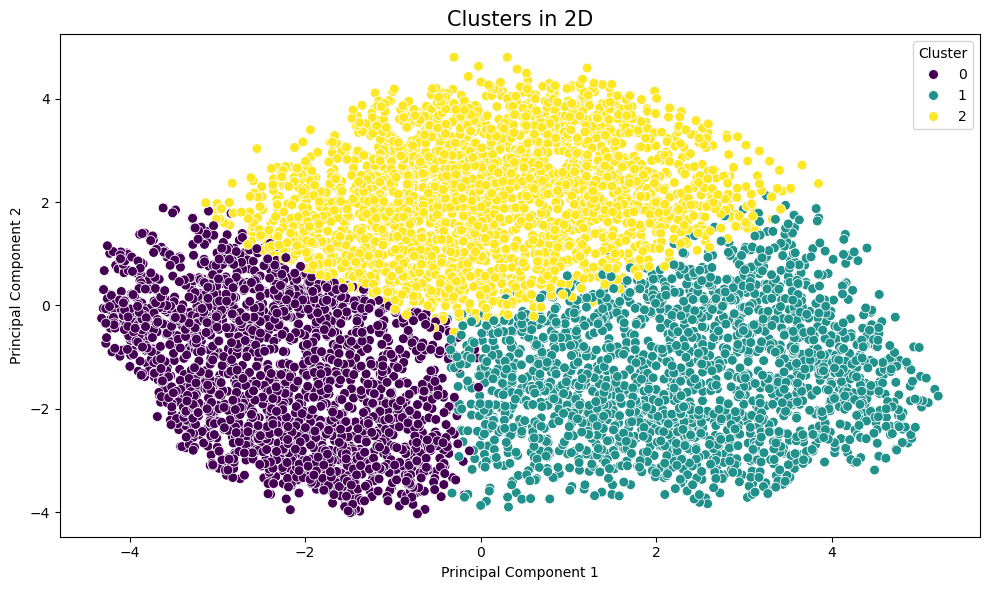

In [103]:
# K-Means clustering

optimal_K = 3
kmeans = KMeans(n_clusters=optimal_K, random_state=42)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

# Add the cluster labels to the dataframe
customer_churn_df_copy['Cluster'] = cluster_labels


# visualize in 2D

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# data frame for visualization

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# plotting
plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=50)
plt.title('Clusters in 2D', fontsize=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [104]:
# Summary statistics for each cluster
cluster_summary = customer_churn_df_copy.groupby('Cluster').mean().T
print(cluster_summary)

Cluster                         0            1            2
City                    17.937146    17.596535    17.992314
Gender                   0.515123     0.498515     0.504996
Senior Citizen           0.037335     0.155446     0.267871
Partner                  0.454159     0.701485     0.337817
Dependents               0.359641     0.280693     0.090699
Tenure Months           27.226371    56.759406    17.807071
Multiple Lines           0.473062     1.353960     0.989623
Paperless Billing        0.327032     0.645050     0.768640
Monthly Charges         29.341352    86.387351    77.051729
Total Charges          752.426583  4964.760000  1455.598616
Churn Value              0.083648     0.082178     0.551883
Churn Score             52.331285    52.389604    68.483859
CLTV                  4285.791588  4959.628218  4061.880861
Churn Reason             0.106263     0.106582     0.515709
Our Services             0.285816     0.175658     0.317917
Payment Method_0         0.207940     0.

#### Cluster Summary Analysis

### CLUSTER 0 -> OverView

- **Demographics:**
  - Gender distribution is roughly balanced (51.5% female, 48.5% male).
  - A very small percentage of senior citizens (3.73%), indicating this cluster likely represents younger customers.

- **Family Structure:**
  - 45.4% have partners, while 35.9% have dependents, suggesting a mix of single and family-oriented customers.

- **Tenure:**
  - Average tenure of 27.23 months indicates a relatively new customer segment.

- **Churn Indicators:**
  - Low churn rate (8.36%) and churn score (52.33) suggest lower risk of churn.
  - Moderate monthly charges ($29.34) and total charges ($752.43) indicate this cluster may represent budget-conscious users.

- **Service Preferences:**
  - High reliance on streaming services (97.78% use streaming services_1, (i.e. They don't Stream)) and multiple lines (47.31%).

- **Internet Usage Preferences:**
   - This cluster includes majority of customers who rely on internet service 2 (i.e. People with Mobile Data) (68.76%) which was probably found to be 'Mobile Data' and they also use internet service 0 which is 'DSL' at the rate of 30.5%. Company can prepare marketing campaigns about internet services, because thes customers are at high risk of churning.


### CLUSTER 1 -> OVERVIEW

- **Demographics:**
  - A noticeable increase in senior citizens (15.54%), hinting at a more diverse age group.

- **Family Structure:**
  - Highest percentage of partners (70.15%), potentially indicating a trend where these customers are more family-oriented.
  - Lowest percentage of dependents (28.07%), which could be linked to the younger demographic and combined households.

- **Tenure:**
  - Significantly longer average tenure (56.76 months), suggesting this cluster contains more established customers.

- **Churn Indicators:**
  - Very low churn rate (8.22%) yet a higher churn score (52.39) implies risk factors might be present despite long tenure.
  - Monthly charges are significantly high ($86.39), indicating higher dissatisfaction or value perception issues given the churn tendencies.

- **Service Preferences:**
  - Moderate use of multiple lines (1.35) and reduced engagement in specific service options (lower usage in streaming compared to Clusters 0 and 2).

- **Internet Usage Prefernces:**
  - This cluster is good at internet services because they don't use mobile data. At 48.3% they use internet service 0, which is DSL and at 51.6% they use internet service 1 which is Fiber Optic. This suggest that they are customers who need high speed internet at 51.6% and customers who need moderate speed internet.

### CLUSTER 2 -> OVERVIEW
- **Demographics:**
  - Highest percentage of senior citizens (26.79%), indicating they might require different service engagement strategies.
  
- **Family Structure:**
  - The lowest proportion of customers with partners (33.78%) and dependents (9.07%), implying these may largely be single users or individuals living alone.

- **Tenure:**
  - Average customer tenure is low (17.81 months), suggesting recent customers or possibly those who have recently had negative experiences. This cluster is at Very High Risk of Churning than other two.

- **Churn Indicators:**
  - Very high churn value (55.19%) and churn score (68.48), indicating a critical risk for churn and urgent attention needed.
  - Considerably higher monthly charges ($77.05) with total charges ($1455.60), possibly indicating dissatisfaction with service for the price paid.

- **Service Preferences:**
  - Highest reliance on Contract_0 (97.42%) which is Month-to-Month, also confirming that this cluster is at high risk of churning.
  - Higher usage of Internet Service_1  which is Fiber Optic (51.63%) suggests a heavy reliance on internet services but lower overall satisfaction. This can also be seen how this is cluster uses 'Our Services' at high rate of 31.8% compared to other clusters but they experienced dissatisfaction

* **


##### 1. **Demographic Insights**

- **Senior Citizens**:
  - **Cluster 0**: 3.73%
  - **Cluster 1**: 15.54%
  - **Cluster 2**: 26.79%
  
  **Inference**: Cluster 2 has the highest proportion of senior citizens, indicating that this group may have different needs and preferences compared to younger customers. Targeted services or marketing strategies could be developed for this demographic.

- **Partner and Dependents**:
  - **Cluster 1** has the highest proportion of customers with partners (70.15%) and a comparatively lower percentage of dependents (28.07%).
  - **Cluster 2** has the lowest percentage of customers with partners (33.78%) and dependents (9.07%).
  
  **Inference**: Cluster 1 is representing families or household units, suggesting opportunities for family-oriented packages or promotions.

##### 2. **Tenure and Loyalty**

- **Tenure Months**:
  - **Cluster 0**: 27.23 months
  - **Cluster 1**: 56.76 months (highest tenure)
  - **Cluster 2**: 17.81 months (lowest tenure)
  
  **Inference**: Cluster 1 comprises long-term customers, which may indicate higher loyalty. Cluster 2's shorter tenure suggests that these customers might be newer or less satisfied, posing a higher risk for churn.

##### 3. **Financial Behavior**

- **Monthly Charges** and **Total Charges**:
  - **Cluster 1** has the highest monthly charges ($86.39) and total charges ($4,964.76), indicating that these customers may be using more services or premium plans.
  - **Cluster 0** has moderate charges, while **Cluster 2** shows significant spending but lower than Cluster 1.
  
  **Inference**: Cluster 1 may represent high-value customers who could be targeted with exclusive offers. Cluster 2, while less valuable, could be at risk of churn due to lower spending.

##### 4. **Churn Scores and Risk**

- **Churn Value**:
  - **Cluster 0**: 0.08
  - **Cluster 1**: 0.08
  - **Cluster 2**: 0.55 (highest churn value)
  
  **Inference**: Cluster 2 has a significantly higher churn value, indicating that these customers are at a high risk of leaving. Strategies to improve retention, such as targeted communications or service improvements, are crucial for this segment.

- **Churn Reason**:
  - **Cluster 2** shows a much higher proportion of customers indicating specific churn reasons (51.57%).
  
  **Inference**: This cluster may require deeper analysis to understand the churn reasons and develop targeted interventions to address their concerns.

##### 5. **Service Usage and Preferences**

- **Streaming Services**:
  - **Cluster 0**: Very low usage of streaming services (1.18%).
  - **Cluster 1**: Moderate usage (15.15%).
  - **Cluster 2**: Higher usage (16.76%).

  **Inference**: Clusters 1 and 2 are more likely to use streaming services, suggesting these customers may appreciate bundled offers that include entertainment options.

- **Payment Methods**:
  - **Cluster 2** shows a significant preference for Payment Method 2 Which is `Electronic check`(63.34%).
  
  **Inference**: A company can use this info to understand payment preferences in order to enhance clients' satisfaction.


##### 6. **Contract Types**

- **Contract Duration**:
  - **Cluster 2** has a high percentage of customers on the month-to-month contract (97.43%).
  - **Cluster 1**, in contrast, has a much lower percentage (10.45%).
  
  **Inference**: Cluster 2's high proportion of month-to-month contracts indicates potential instability and may be a target for contract incentives to encourage longer commitments.

* **

**Since K-Means has successfully differentiated the data into distinct, well-separated clusters without any scattered points or noise, there is not need to use DBSCAN for this dataset to detect Outliers. K-Means has well provided an adequate clustering solution.**

### 2. Dimensionality Reduction - PCA

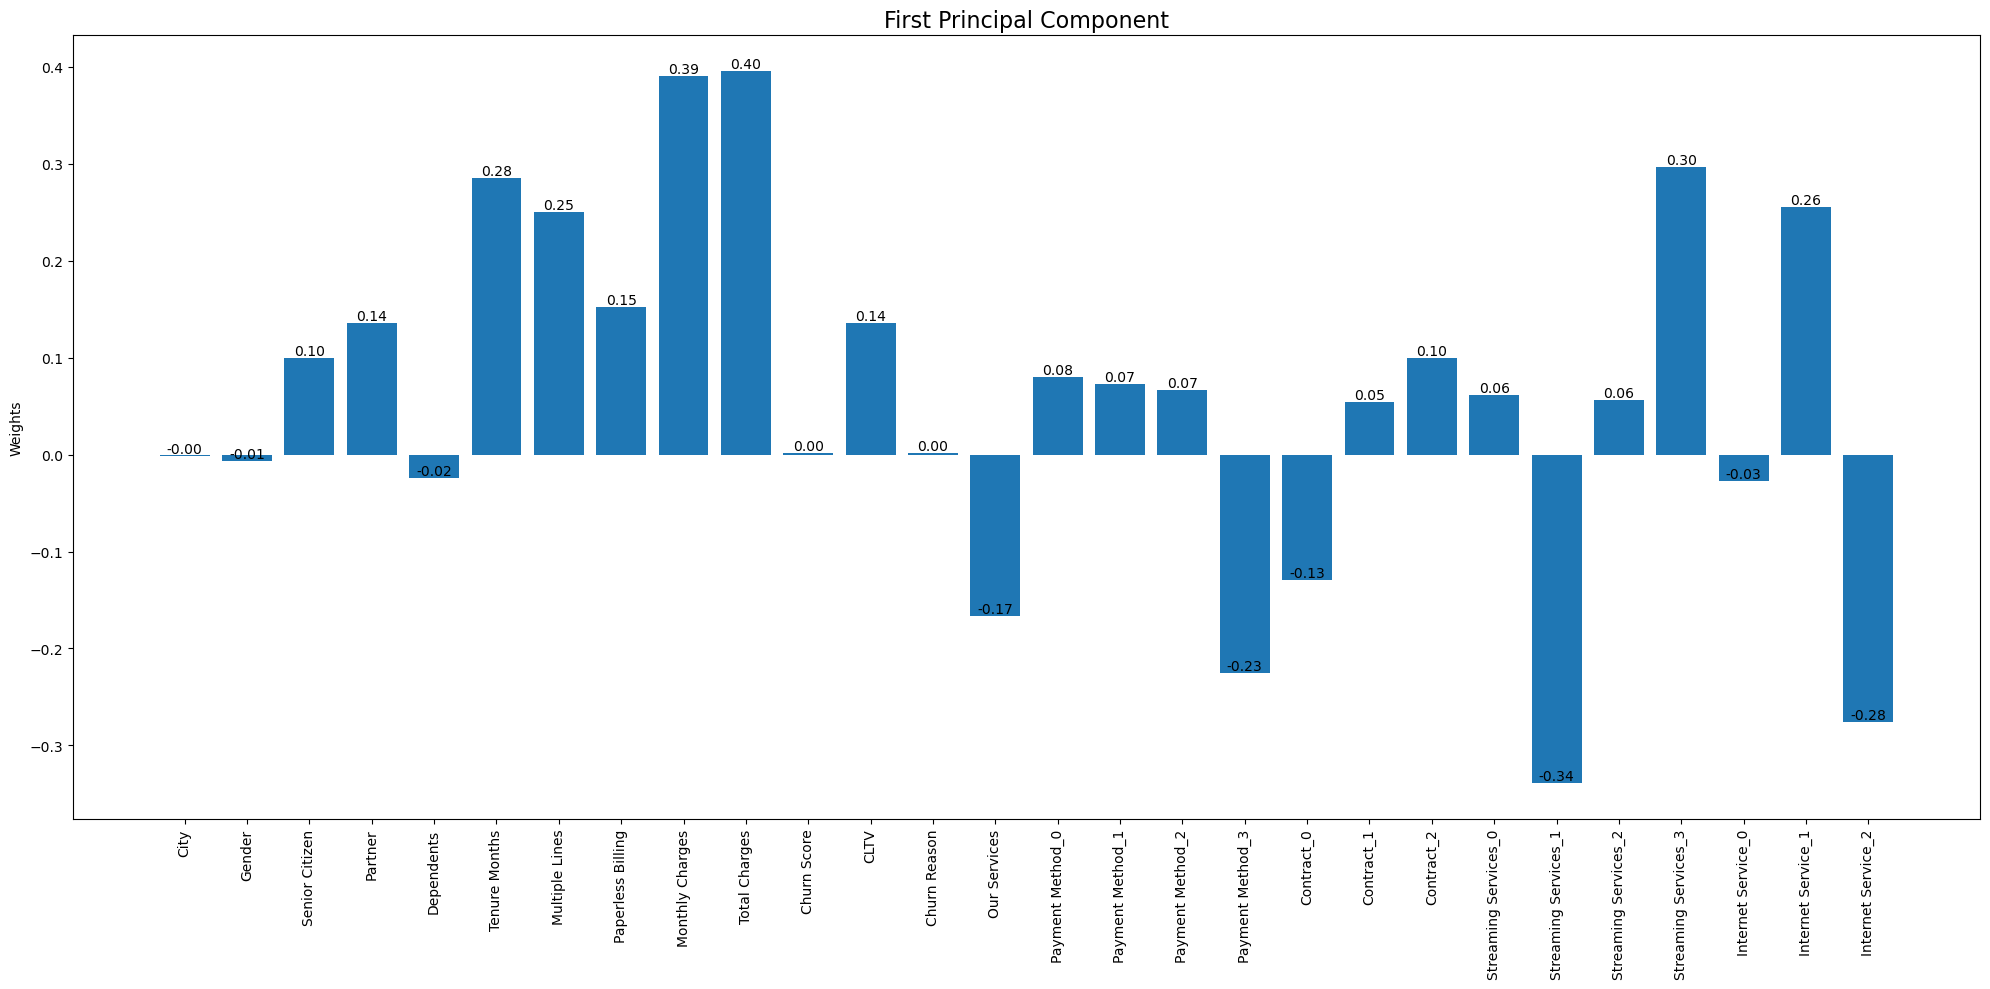

In [105]:

pca = PCA()
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

# Add feature names on x-axis
features = X.columns

# first PC
plt.figure(figsize=(20, 10))
plt.bar(features, pca.components_[0])
plt.title('First Principal Component', fontsize=16)
plt.xticks(rotation=90)
plt.ylabel('Weights')

# Add value on top of each bar
for i, v in enumerate(pca.components_[0]):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Feature Contributions:**
   - The **first principal component** is primarily influenced by certain features that have relatively high positive or negative weights:
      - Total Chrages (0.4), Monthly Charges (0.39),Internet Service_2 (-0.28),Payment Method_3 (-0.34),Streaming Services_1 (0.30), Multiple Lines (0.28), and Paperless Billing (0.25)
      - The first principal component captures a significant amount of variance in the data, particularly focussing on economic aspects like charges and payment methods.


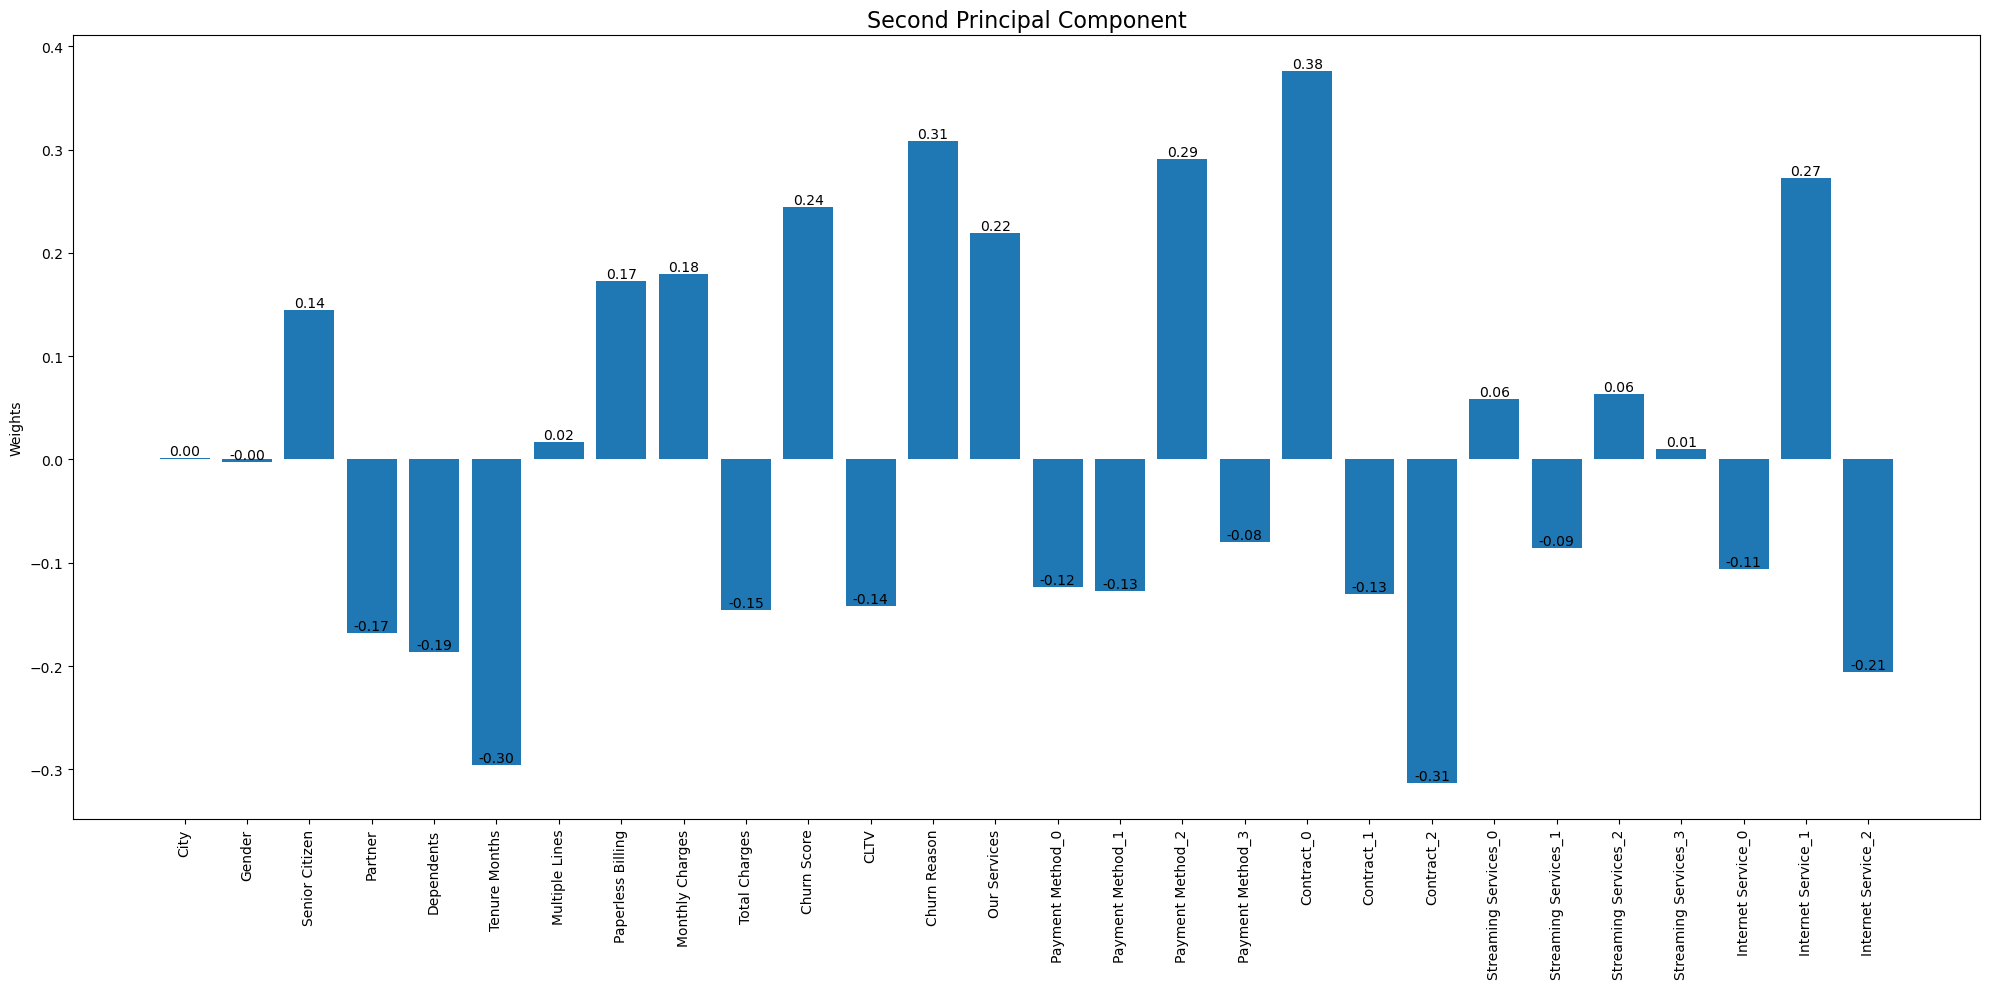

In [106]:


pca = PCA()
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
# Add feature names on x-axis
features = X.columns

# first PC
plt.figure(figsize=(20, 10))
plt.bar(features, pca.components_[1])
plt.title('Second Principal Component', fontsize=16)
plt.xticks(rotation=90)
plt.ylabel('Weights')

# Add value on top of each bar
for i, v in enumerate(pca.components_[1]):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

- The positive contributions to PC2 from streaming services and specific contracts indicate that this component may capture customer preferences and behaviors related to service usage

- The negative association with dependents and tenure points to a potential life stage factor, where customers without dependents and with shorter tenures may exhibit different service preferences

- The negative weights on total and monthly charges suggest that customers with higher spending may also be less aligned with the characteristics represented in PC2, possibly reflecting dissatisfaction or financial constraints

In [107]:
pca = PCA()
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

def main_contributors(component, n=10):
    abs_weights = np.abs(component)
    sorted_indices = np.argsort(abs_weights)[::-1]
    top_indices = sorted_indices[:n]
    top_features = X.columns[top_indices]
    top_contributions = component[top_indices]
    return list(zip(top_features, top_contributions))

# first principal component
top_contributors = main_contributors(pca.components_[0])
print("Top contributors for the first principal component:")
print('='*50)
for feature, contribution in top_contributors:
    print(f"{feature}: {contribution:.4f}")



Top contributors for the first principal component:
Total Charges: 0.3959
Monthly Charges: 0.3910
Streaming Services_1: -0.3389
Streaming Services_3: 0.2965
Tenure Months: 0.2849
Internet Service_2: -0.2761
Internet Service_1: 0.2551
Multiple Lines: 0.2501
Payment Method_3: -0.2251
Our Services: -0.1669


In [108]:
# first principal component
top_contributors = main_contributors(pca.components_[1])
print("Top contributors for the second principal component:")
print('='*50)
for feature, contribution in top_contributors:
    print(f"{feature}: {contribution:.4f}")


Top contributors for the second principal component:
Contract_0: 0.3761
Contract_2: -0.3134
Churn Reason: 0.3082
Tenure Months: -0.2962
Payment Method_2: 0.2905
Internet Service_1: 0.2721
Churn Score: 0.2447
Our Services: 0.2191
Internet Service_2: -0.2061
Dependents: -0.1865


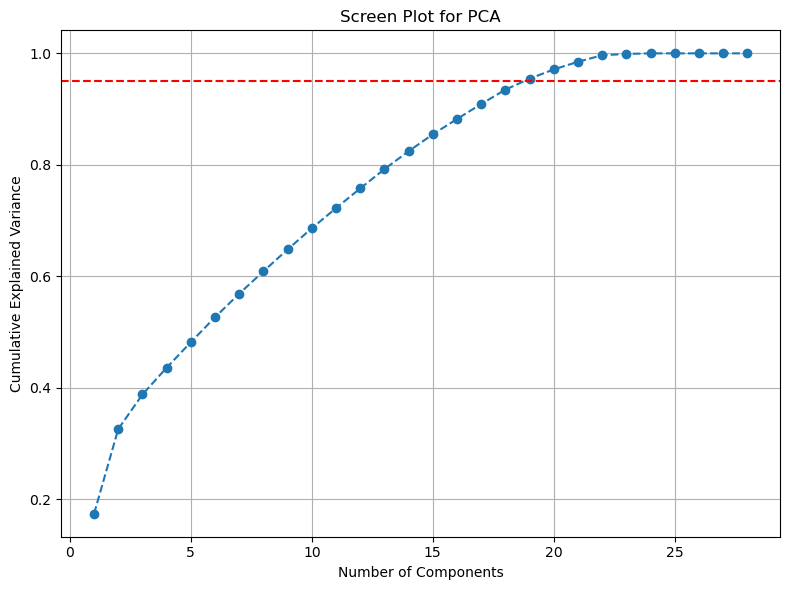


Number of components to explain 95% variance: 19


In [109]:
# screen plot for pca, to know how many components needed to meet 95% variance
plt.figure(figsize=(8, 6))

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Screen Plot for PCA')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()
# components for 95% variance
components_for_95_percent = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"\nNumber of components to explain 95% variance: {components_for_95_percent}")


#### Summary Table for Unsupervised Learning

In [110]:
# Show one-hot column names
print("One-Hot Encoding Column Names:", one_hot_encoder.get_feature_names_out(['Internet Service']))

One-Hot Encoding Column Names: ['Internet Service_DSL' 'Internet Service_Fiber optic'
 'Internet Service_No']


- We can see that Decoding is based on Alphabetical Order.

In [111]:
customer_churn_df['Streaming Services'].value_counts()

# One-hot encoding for 'Streaming Services'
one_hot_encoder.fit(customer_churn_df[['Streaming Services']])
print("One-Hot Encoding Column Names:", one_hot_encoder.get_feature_names_out(['Streaming Services']))

One-Hot Encoding Column Names: ['Streaming Services_Movies' 'Streaming Services_No Streaming'
 'Streaming Services_TV' 'Streaming Services_TV & Movies']


In [112]:
# One-hot encoding for 'Payment Method'
one_hot_encoder.fit(customer_churn_df[['Payment Method']])
print("One-Hot Encoding Column Names:", one_hot_encoder.get_feature_names_out(['Payment Method']))

One-Hot Encoding Column Names: ['Payment Method_Bank transfer (automatic)'
 'Payment Method_Credit card (automatic)'
 'Payment Method_Electronic check' 'Payment Method_Mailed check']


In [113]:
# One-hot encoding for 'Contract'
one_hot_encoder.fit(customer_churn_df[['Contract']])
print("One-Hot Encoding Column Names:", one_hot_encoder.get_feature_names_out(['Contract']))

One-Hot Encoding Column Names: ['Contract_Month-to-month' 'Contract_One year' 'Contract_Two year']


In [114]:
# K-Means summary table data
cluster_data = {
    "Feature": [
        "City", "Gender", "Senior Citizen", "Partner", "Dependents", "Tenure Months",
        "Multiple Lines", "Paperless Billing", "Monthly Charges", "Total Charges",
        "Churn Value", "Churn Score", "CLTV", "Churn Reason", "Our Services",
        "Payment Method_Bank Transfer", "Payment Method_Credit Card", "Payment Method_Electronic Check", "Payment Method_Mailed Check",
        "Contract_Month-to-Month", "Contract_One year", "Contract_Two year", "Streaming Services_Movies", 
        "Streaming Services_No Streaming", "Streaming Services_TV", "Streaming Services_TV & Movies",
        "Internet Service_DSL", "Internet Service_Fiber optic", "Internet Service_No"
    ],
    "Cluster 0": [
        17.937146, 0.515123, 0.037335, 0.454159, 0.359641, 27.226371, 
        0.473062, 0.327032, 29.341352, 752.426583, 0.083648, 52.331285, 
        4285.791588, 0.106263, 0.285816, 0.207940, 0.204159, 0.083176, 
        0.504726, 0.448488, 0.236767, 0.314745, 0.011815, 0.977788, 
        0.007089, 0.003308, 0.305766, 0.006616, 0.687618
    ],
    "Cluster 1": [
        17.596535, 0.498515, 0.155446, 0.701485, 0.280693, 56.759406, 
        1.353960, 0.645050, 86.387351, 4964.760000, 0.082178, 52.389604, 
        4959.628218, 0.106582, 0.175658, 0.352970, 0.338614, 0.217327, 
        0.091089, 0.104455, 0.421287, 0.474257, 0.151485, 0.131683, 
        0.134653, 0.582178, 0.483663, 0.516337, 0.000000
    ],
    "Cluster 2": [
        17.992314, 0.504996, 0.267871, 0.337817, 0.090699, 17.807071, 
        0.989623, 0.768640, 77.051729, 1455.598616, 0.551883, 68.483859, 
        4061.880861, 0.515709, 0.317917, 0.132590, 0.124904, 0.633359, 
        0.109147, 0.974251, 0.023444, 0.002306, 0.167563, 0.401998, 
        0.171407, 0.259032, 0.260953, 0.738278, 0.000769
    ]
}

# Creating a DataFrame
df = pd.DataFrame(cluster_data)
table = tabulate(df, headers="keys", tablefmt="fancy_grid", floatfmt=".6f")

# Print the table
print(table)


╒════╤═════════════════════════════════╤═════════════╤═════════════╤═════════════╕
│    │ Feature                         │   Cluster 0 │   Cluster 1 │   Cluster 2 │
╞════╪═════════════════════════════════╪═════════════╪═════════════╪═════════════╡
│  0 │ City                            │   17.937146 │   17.596535 │   17.992314 │
├────┼─────────────────────────────────┼─────────────┼─────────────┼─────────────┤
│  1 │ Gender                          │    0.515123 │    0.498515 │    0.504996 │
├────┼─────────────────────────────────┼─────────────┼─────────────┼─────────────┤
│  2 │ Senior Citizen                  │    0.037335 │    0.155446 │    0.267871 │
├────┼─────────────────────────────────┼─────────────┼─────────────┼─────────────┤
│  3 │ Partner                         │    0.454159 │    0.701485 │    0.337817 │
├────┼─────────────────────────────────┼─────────────┼─────────────┼─────────────┤
│  4 │ Dependents                      │    0.359641 │    0.280693 │    0.090699 │
├───

## Supervised Learning

**A. Random Forest Classifier**
* **

In [115]:
str_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # stratified kfold
rf_model = RandomForestClassifier(random_state=42)

In [116]:
# rf_params ={
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [5, 10, 15, 20, 25],
#     'min_samples_split': [2, 5, 10, 15, 20],
#     'min_samples_leaf': [1, 2, 5, 10],
#     'max_features': [None, 'sqrt', 'log2'],
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'bootstrap': [True, False]
# }

# random_search_rf = RandomizedSearchCV(rf_model,
#                                        rf_params, 
#                                        n_iter=200, 
#                                        scoring='accuracy', 
#                                        n_jobs=-1, 
#                                        cv=str_kfold, 
#                                        random_state=42)

#  # no need to use scaled data for random forest

# random_search_rf.fit(X_train, y_train)

# print("Best Parameters: ", random_search_rf.best_params_)

In [117]:
# best parameters found
# due to high time taking to run the model in cell above, 
# I will write the best parameters found, codes will be commented after getting best parameters

rf_best_random_params ={'n_estimators': 300, 
                        'min_samples_split': 20,
                          'min_samples_leaf': 2, 
                          'max_features': 'sqrt', 
                          'max_depth': 15, 
                          'criterion': 'gini', 
                          'bootstrap': True}

rf_best_model = RandomForestClassifier(random_state=42, **rf_best_random_params)

rf_best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=20,
                       n_estimators=300, random_state=42)

In [118]:
# accuracy on train data
train_preds_rf = rf_best_model.predict(X_train)
train_accuracy_rf = accuracy_score(y_train, train_preds_rf)

# accuracy on test data
test_preds_rf = rf_best_model.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, test_preds_rf)


# f1 score on test data
f1_rf = f1_score(y_test, test_preds_rf)

# roc-auc
roc_auc_rf = roc_auc_score(y_test, test_preds_rf)

# printing the results
print("Random Forest Classifier")
print('='*70)
print(f"Accuracy on Train Data: {train_accuracy_rf:.4f}")
print(f"Accuracy on Test Data: {test_accuracy_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"ROC-AUC Score: {roc_auc_rf:.4f}")

Random Forest Classifier
Accuracy on Train Data: 0.9873
Accuracy on Test Data: 0.9893
F1 Score: 0.9795
ROC-AUC Score: 0.9819


**B. XGBoost Classifier**
* **

In [119]:
# xgb = XGBClassifier(random_state=42)

# xgb_params = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [3, 5, 7, 9, 11],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4],
#     'min_child_weight': [1, 3, 5, 7]
# }

# random_search_xgb = RandomizedSearchCV(xgb,
#                                        xgb_params,
#                                        n_iter=200,
#                                        scoring='accuracy',
#                                        n_jobs=-1,
#                                        cv=str_kfold,
#                                        random_state=42)

# random_search_xgb.fit(X_train, y_train)

# print("Best Parameters: ", random_search_xgb.best_params_)

In [120]:
# since hyperparameter tuning is taking too long to run, let's write the found best parameters.
xgb_best_random_params = {'subsample': 0.7, 
                          'n_estimators': 200, 
                          'min_child_weight': 1, 
                          'max_depth': 7, 
                          'learning_rate': 0.01, 
                          'gamma': 0, 
                          'colsample_bytree': 0.6}

xgb_best_model = XGBClassifier(random_state=42, **xgb_best_random_params)

xgb_best_model.fit(X_train, y_train)

# accuracy on train data
train_preds_xgb = xgb_best_model.predict(X_train)
train_accuracy_xgb = accuracy_score(y_train, train_preds_xgb)

# accuracy on test data
test_preds_xgb = xgb_best_model.predict(X_test)
test_accuracy_xgb = accuracy_score(y_test, test_preds_xgb)

# f1 score on test data
f1_xgb = f1_score(y_test, test_preds_xgb)

# roc-auc
roc_auc_xgb = roc_auc_score(y_test, test_preds_xgb)

# printing the results
print("XGBoost Classifier")
print('='*70)
print(f"Accuracy on Train Data: {train_accuracy_xgb:.4f}")
print(f"Accuracy on Test Data: {test_accuracy_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")



XGBoost Classifier
Accuracy on Train Data: 0.9875
Accuracy on Test Data: 0.9887
F1 Score: 0.9783
ROC-AUC Score: 0.9808


**C. Voting Classifier**
* **

*C.1. Support Vector Machines*

In [121]:

svc = SVC(random_state=42)

svc_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

random_search_svc = RandomizedSearchCV(svc,
                                        svc_params,
                                        n_iter=200,
                                        scoring='accuracy',
                                        n_jobs=-1,
                                        cv=str_kfold,
                                        random_state=42)

random_search_svc.fit(X_train_scaled, y_train)

print("Best Parameters: ", random_search_svc.best_params_)


Best Parameters:  {'kernel': 'linear', 'gamma': 'scale', 'C': 10}


In [122]:
svc_best_random_params = random_search_svc.best_params_
svc_best_model = SVC(random_state=42, **svc_best_random_params)
svc_best_model.fit(X_train_scaled, y_train)

SVC(C=10, kernel='linear', random_state=42)

*C.2. Logistic Regression*

In [123]:
logit = LogisticRegression(random_state=42)

logit.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

*C.3. K-Nearest Neighbors*

In [124]:
knn = KNeighborsClassifier()

knn_params = {
    'n_neighbors': range(5,21),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2] # hen p = 1, this is equivalent
        #to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.
}

random_search_knn = RandomizedSearchCV(knn,
                                        knn_params,
                                        n_iter=200,
                                        scoring='accuracy',
                                        n_jobs=-1,
                                        cv=str_kfold,
                                        random_state=42)

random_search_knn.fit(X_train_scaled, y_train)

print("Best Parameters: ", random_search_knn.best_params_)

Best Parameters:  {'weights': 'distance', 'p': 2, 'n_neighbors': 18, 'algorithm': 'auto'}


In [125]:
knn_best_random_params = random_search_knn.best_params_

knn_best_model = KNeighborsClassifier(**knn_best_random_params)

knn_best_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=18, weights='distance')

**C.4. Decision Tree**

In [126]:
dt = DecisionTreeClassifier(random_state=42)

dt_params = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

random_search_dt = RandomizedSearchCV(dt,
                                        dt_params,
                                        n_iter=200,
                                        scoring='accuracy',
                                        n_jobs=-1,
                                        cv=str_kfold,
                                        random_state=42)


random_search_dt.fit(X_train, y_train)

print("Best Parameters: ", random_search_dt.best_params_)

Best Parameters:  {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 5, 'criterion': 'entropy'}


In [127]:
dt_best_random_params = random_search_dt.best_params_

dt_best_model = DecisionTreeClassifier(random_state=42, **dt_best_random_params)

dt_best_model.fit(X_train, y_train)



DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       min_samples_split=5, random_state=42)

**Voting Classifier**

In [128]:
# Create a voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('knn', knn_best_model),
        ('dt', dt_best_model),
        ('logit', logit),
        ('svc', svc_best_model)
    ],
    voting='hard'  # 
)

# Fit the voting classifier on the training data
voting_clf.fit(X_train_scaled, y_train)

# Predict on the test data
test_preds_voting = voting_clf.predict(X_test_scaled)

# Calculate metrics
train_accuracy_voting = accuracy_score(y_train, voting_clf.predict(X_train_scaled))
test_accuracy_voting = accuracy_score(y_test, test_preds_voting)
f1_voting = f1_score(y_test, test_preds_voting)
roc_auc_voting = roc_auc_score(y_test, test_preds_voting)

# Print the results
print("Voting Classifier")
print('='*70)
print(f"Accuracy on Train Data: {train_accuracy_voting:.4f}")
print(f"Accuracy on Test Data: {test_accuracy_voting:.4f}")
print(f"F1 Score: {f1_voting:.4f}")
print(f"ROC-AUC Score: {roc_auc_voting:.4f}")

Voting Classifier
Accuracy on Train Data: 0.9842
Accuracy on Test Data: 0.9840
F1 Score: 0.9689
ROC-AUC Score: 0.9711


**=> Selecting the best supervised model**
* **

In [129]:
# Define the models and their respective metrics
models = {
    'Voting Classifier': {
        'f1': f1_voting,
        'test_accuracy': test_accuracy_voting,
        'roc_auc': roc_auc_voting
    },
    'XGBoost Classifier': {
        'f1': f1_xgb,
        'test_accuracy': test_accuracy_xgb,
        'roc_auc': roc_auc_xgb
    },
    'Random Forest Classifier': {
        'f1': f1_rf,
        'test_accuracy': test_accuracy_rf,
        'roc_auc': roc_auc_rf
    }
}

# Function to choose the best model
def choose_best_model(models):
    best_model = None
    best_score = -1

    for model_name, metrics in models.items():
        # Calculate the average score of the metrics
        avg_score = (metrics['f1'] + metrics['test_accuracy'] + metrics['roc_auc']) / 3

        if avg_score > best_score:
            best_score = avg_score
            best_model = model_name

    return best_model

# Choose the best model
best_model = choose_best_model(models)
print(f"The best model is: {best_model}")


# Extract metrics for the best model
best_model_metrics = models[best_model]

# Print the metrics of the best model
print(f"Metrics for the best model ({best_model}):")
print(f"F1 Score: {best_model_metrics['f1']:.4f}")
print(f"Test Accuracy: {best_model_metrics['test_accuracy']:.4f}")
print(f"ROC-AUC Score: {best_model_metrics['roc_auc']:.4f}")


The best model is: Random Forest Classifier
Metrics for the best model (Random Forest Classifier):
F1 Score: 0.9795
Test Accuracy: 0.9893
ROC-AUC Score: 0.9819


#### Comparison Table for supervised Learning

In [130]:
models = {
    'Voting Classifier': {
        'f1': f1_voting,
        'test_accuracy': test_accuracy_voting,
        'roc_auc': roc_auc_voting
    },
    'XGBoost Classifier': {
        'f1': f1_xgb,
        'test_accuracy': test_accuracy_xgb,
        'roc_auc': roc_auc_xgb
    },
    'Random Forest Classifier': {
        'f1': f1_rf,
        'test_accuracy': test_accuracy_rf,
        'roc_auc': roc_auc_rf
    }
}

# Create a list of rows for the table
table_data = []
for model_name, metrics in models.items():
    row = [model_name, metrics['f1'], metrics['test_accuracy'], metrics['roc_auc']]
    table_data.append(row)

# Define the headers
headers = ["Model", "F1 Score", "Test Accuracy", "ROC-AUC Score"]

# Create the table
table = tabulate(table_data, headers=headers, tablefmt="fancy_grid", floatfmt=".4f")

# Print the table
print(table)

╒══════════════════════════╤════════════╤═════════════════╤═════════════════╕
│ Model                    │   F1 Score │   Test Accuracy │   ROC-AUC Score │
╞══════════════════════════╪════════════╪═════════════════╪═════════════════╡
│ Voting Classifier        │     0.9689 │          0.9840 │          0.9711 │
├──────────────────────────┼────────────┼─────────────────┼─────────────────┤
│ XGBoost Classifier       │     0.9783 │          0.9887 │          0.9808 │
├──────────────────────────┼────────────┼─────────────────┼─────────────────┤
│ Random Forest Classifier │     0.9795 │          0.9893 │          0.9819 │
╘══════════════════════════╧════════════╧═════════════════╧═════════════════╛


## Integrating Supervised and Unsupervised- deeper insights.

In [131]:
# Remove 'Cluster' and 'Churn Value' columns from the dataset
X_full = customer_churn_df_copy.drop(['Cluster', 'Churn Value'], axis=1)

# Ensuring the feature names match those used during training
X_full = X_full[X_train.columns]

# no need to scale the data for random forest

# Predict churn risk using the best model
churn_risk = rf_best_model.predict(X_full)

# Add the churn risk predictions to the dataframe
customer_churn_df_copy['churn_risk'] = churn_risk

In [132]:
# Calculate the risk by cluster
risk_by_cluster = customer_churn_df_copy.groupby('Cluster')['churn_risk'].mean()

# Print the risk by cluster
print("Risk by Cluster:")
print(risk_by_cluster)

Risk by Cluster:
Cluster
0    0.078922
1    0.076733
2    0.530746
Name: churn_risk, dtype: float64


**High Risk Churn => Cluster 2**

- The churn risk for Cluster 2 is 53.07%, significantly higher than Clusters 0 and 1 (both around 7.6%).
- This indicates that customers in this cluster are at a much greater risk of leaving the service.

- A high percentage (97.43%) of customers in Cluster 2 are on a month-to-month contract, which typically indicates less commitment and higher churn likelihood compared to one- or two-year contracts. This is a critical factor suggesting these customers can leave.

- A significant portion of customers (approximately 63.34%) use Electronic Check as a payment method. This also indicate a demographic that is less engaged or less willing to commit to automatic payments, making them more likely to churn.

- The average monthly charges for customers in Cluster 2 are $77.05, which is lower than Cluster 1 but higher than Cluster 0. Price sensitivity among these customers might be a contributing factor to their higher churn risk.

- Cluster 2 shows a relatively high engagement with Streaming Services (around 40%), which could indicate that these services are important to this customer segment. If they feel that the service does not meet their expectations, it could lead to increased churn.

#### Recommended Actions for Cluster 2

- Introducing loyalty programs or incentives for long-term contracts to encourage customers to transition from month-to-month plans to longer commitments.

- Establishing feedback channels to understand the specific pain points of customers in this cluster and addressing them promptly.

- Offering discounts for automatic payment options could enhance retention

- Providing guides or tutorials for benefits of using other services such as online security, device protection, online backups.

#### Summary Table for Integration

In [133]:

summary_data = [
    ["Cluster", "Churn Risk", "Insights", "Recommended Actions"],
    ["Cluster 0", "7.89%", 
     "- Balanced gender distribution\n- Low percentage of senior citizens(3.73%)\n- Moderate monthly charges\n- Low reliance on streaming services\n- Mix of Partners(45.5%) and Dependents(35.9%) (family-oriented)",
     "- Maintaining current service quality\n- Monitoring for any emerging issues\n- Marketing the use of internet services"],
    ["Cluster 1", "7.67%", 
     "- Higher percentage of senior citizens(15.52%)\n- High percentage of customers with partners(70.17%)\n- Long percentage of dependents(28.07%)\n- This suggests mix of youngs, couples, senior and less dependents\n- High monthly charges\n- Zero use of mobile data.",
     "- Provide reliable internet speeds.\n- Provide loyalty rewards for long-term customers"],
    ["Cluster 2", "53.07%", 
     "- High percentage on month-to-month contracts\n- Significant use of Electronic Check\n- Higher monthly charges\n- High engagement with streaming services and Fiber Optic Internet\n-Possible dissatisfaction with current services",
     "- Introduce loyalty programs\n- Establish feedback channels\n- Offer discounts for automatic payments\n- Provide guides for additional services"]
]

# Create the table
summary_table = tabulate(summary_data, headers="firstrow", tablefmt="fancy_grid")

# Print the table
print(summary_table)

╒═══════════╤══════════════╤════════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════╕
│ Cluster   │ Churn Risk   │ Insights                                                           │ Recommended Actions                               │
╞═══════════╪══════════════╪════════════════════════════════════════════════════════════════════╪═══════════════════════════════════════════════════╡
│ Cluster 0 │ 7.89%        │ - Balanced gender distribution                                     │ - Maintaining current service quality             │
│           │              │ - Low percentage of senior citizens(3.73%)                         │ - Monitoring for any emerging issues              │
│           │              │ - Moderate monthly charges                                         │ - Marketing the use of internet services          │
│           │              │ - Low reliance on streaming services                               │   

* **